## Librerie

In [ ]:
import pandas as pd
import math
import numpy as np
import tensorflow as tf
import sklearn
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, roc_auc_score, roc_curve, accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_val_predict, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, RepeatedStratifiedKFold

from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz
from IPython.display import Image
from sklearn.ensemble import RandomForestClassifier , AdaBoostClassifier

from scipy.stats import reciprocal
import seaborn as sns
from pandas_profiling import ProfileReport

%matplotlib inline

In [ ]:
#plt.style.use('ggplot')
sns.set_theme()
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 15
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8

colors = ['xkcd:navy', 'xkcd:lawn green', 'xkcd:dark red', 'xkcd:dark orange', 'xkcd:terra cotta', 'xkcd:purple', 'xkcd:teal', 'xkcd:goldenrod', 'xkcd:cadet blue',
          'xkcd:crimson', 'xkcd:dark violet']

## INTRODUZIONE AL DATASET
HTRU2 è un dataset che descrive un campione di candidati pulsar raccolti durante l'High Time Resolution Universe (HTRU) survey [1].

L'HTRU survey è un'indagine di tutto il cielo per pulsar e transitori radio di breve durata, con un forte focus sulle basse latitudini galattiche, dove viene utilizzata maggiormente la risoluzione di frequenza più alta per la negazione della dispersione interstellare. Le onde radio emesse dalle pulsar raggiungono la Terra dopo aver percorso lunghe distanze nello spazio pieno di elettroni liberi. L'emissione radio delle pulsar subisce una dispersione a causa della presenza di elettroni liberi nel mezzo interstellare (ISM). Le pulsar emettono un'ampia gamma di frequenze e la quantità di onda rallentata dagli elettroni dipende dalla frequenza. Le onde con frequenza minore vengono rallentate meno rispetto alle onde con frequenza maggiore. Il ritardo dispersivo nel tempo di arrivo del segnale della pulsar cambia nel tempo a causa della diversa densità di elettroni ISM lungo la linea di vista.


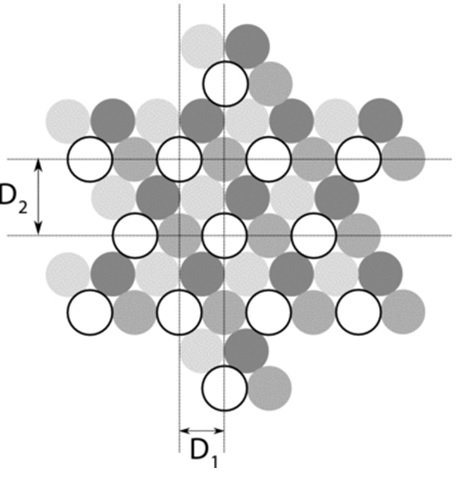

Il pattern del raggio del ricevitore multibeam. I cerchi neri indicano i 14 arcmin FWHM di ciascuno dei 13 raggi del ricevitore. Anche la separazione D1 è uguale a 14 arcmin FWHM e D2=$\sqrt{3}$ D1.

Immagine presa da [1].

Le pulsar sono un raro tipo di stella di neutroni che producono emissioni radio rilevabili qui sulla Terra. Sono di notevole interesse scientifico come sonde dello spazio-tempo, del mezzo interstellare e degli stati della materia [2].

Mentre le pulsar ruotano, il loro raggio di emissione attraversa il cielo e, quando questo attraversa la nostra linea di vista, produce uno schema rilevabile di emissione radio a banda larga. Poiché le pulsar ruotano rapidamente, questo schema si ripete periodicamente. Quindi la ricerca di pulsar implica la ricerca di segnali radio periodici con grandi radiotelescopi.

Ogni pulsar produce uno schema di emissione leggermente diverso, che varia leggermente ad ogni rotazione. Quindi un potenziale rilevamento di segnale noto come "candidato", viene mediato su molte rotazioni della pulsar, come determinato dalla lunghezza di un'osservazione. In assenza di ulteriori informazioni, ogni candidato potrebbe potenzialmente descrivere una vera pulsar. Tuttavia, in pratica, quasi tutti i rilevamenti sono causati da interferenze a radiofrequenza (RFI) e rumore, che rendono difficili da trovare i segnali legittimi.

Gli strumenti di Machine Learning vengono ora utilizzati per etichettare automaticamente i candidati pulsar per facilitare un'analisi rapida. In particolare, sono ampiamente adottati sistemi di classificazione [3][4], che trattano i dataset dei candidati come problemi di classificazione binaria. Qui gli esempi legittimi di pulsar sono una classe positiva minoritaria e gli esempi spuri la classe maggioritaria negativa.

Questo dataset contiene 16.259 esempi spuri causati da RFI/rumore e 1.639 esempi di pulsar reali.

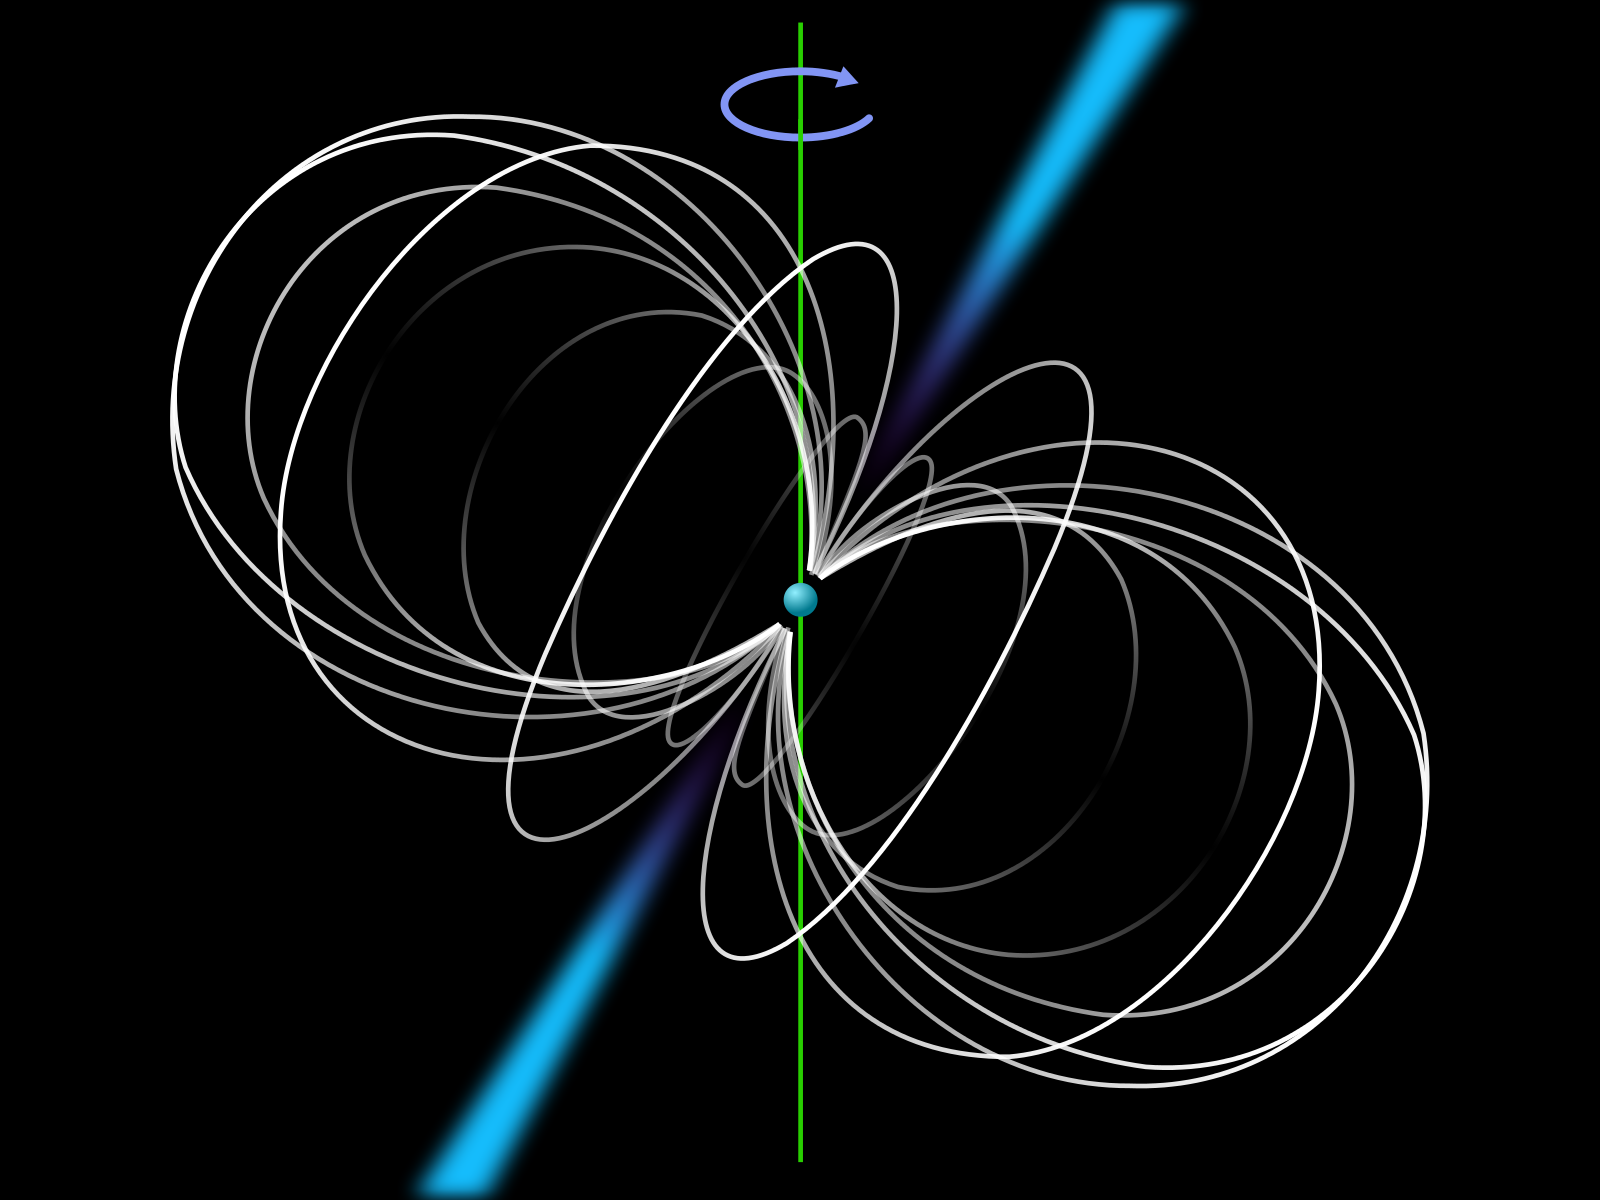


Vista schematica di una pulsar. La sfera al centro rappresenta la stella di neutroni, le curve indicano le linee del campo magnetico, i coni sporgenti rappresentano i fasci di emissione e la linea verde rappresenta l'asse su cui ruota la stella.

Immagine presa da https://en.wikipedia.org/wiki/Pulsar

In [ ]:
dataset=pd.read_csv('Pulsar.csv', sep=',')
#dataset= dataset.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=True)  #eliminiamo le righe duplicate
dataset

Mean_Integrated         SD  ...  Skewness_DMSNR_Curve  Class
0           140.562500  55.683782  ...             74.242225      0
1           102.507812  58.882430  ...            127.393580      0
2           103.015625  39.341649  ...             63.171909      0
3           136.750000  57.178449  ...             53.593661      0
4            88.726562  40.672225  ...            252.567306      0
...                ...        ...  ...                   ...    ...
17893       136.429688  59.847421  ...            285.931022      0
17894       122.554688  49.485605  ...              8.297092      0
17895       119.335938  59.935939  ...              4.595173      0
17896       114.507812  53.902400  ...            134.238910      0
17897        57.062500  85.797340  ...              1.429475      0

[17898 rows x 9 columns]

## Informazioni sulle features:

Ogni candidato è descritto da 8 variabili continue e una singola variabile di classe (il target). Le prime quattro variabili continue sono semplici statistiche ottenute dal profilo di impulso integrato (integrated pulse profile). Le restanti quattro variabili sono similmente ottenute dalla curva DM-SNR (è una curva legata alla misura della dispersione delle onde radio delle pulsar).


Features (Based on Integrated Profile of Observation):

Mean_Integrated: Media delle osservazioni (Mean of Observations)

SD: Deviazione Standard delle osservazion (Standard deviation of Observations)

EK: Eccesso di kurtosis delle osservazioni (Excess kurtosis of Observations)

Skewness: Nella teoria della probabilità e nella statistica, la skewness è una misura dell'asimmetria della distribuzione di probabilità di una variabile casuale, a valori reali, rispetto alla sua media. Skewness delle osservazioni (Skewness of Observations)

Mean _ DMSNR _ Curve: Media della curva DM-SNR delle osservazioni (Mean of DM SNR CURVE of Observations)

SD _ DMSNR _ Curve: Deviazione Standard della curva DM-SNR delle osservazioni (Standard deviation of DM SNR CURVE of Observations)

EK _ DMSNR _ Curve: Eccesso di kurtosis della curva DM-SNR delle osservazioni (Excess kurtosis of DM SNR CURVE of Observations)

Skewness _ DMSNR _ Curve: Skewness della curva DM-SNR delle osservazioni (Skewness of DM SNR CURVE of Observations)

Class: Classe 0 - 1

TARGET:

Classe

0 -- non è una pulsar

1 -- è una pulsar

In [ ]:
#! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
profile = ProfileReport(dataset, title = 'Pandas Profiling report of "dataset"', html = {'style':{'full_width': True}})
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

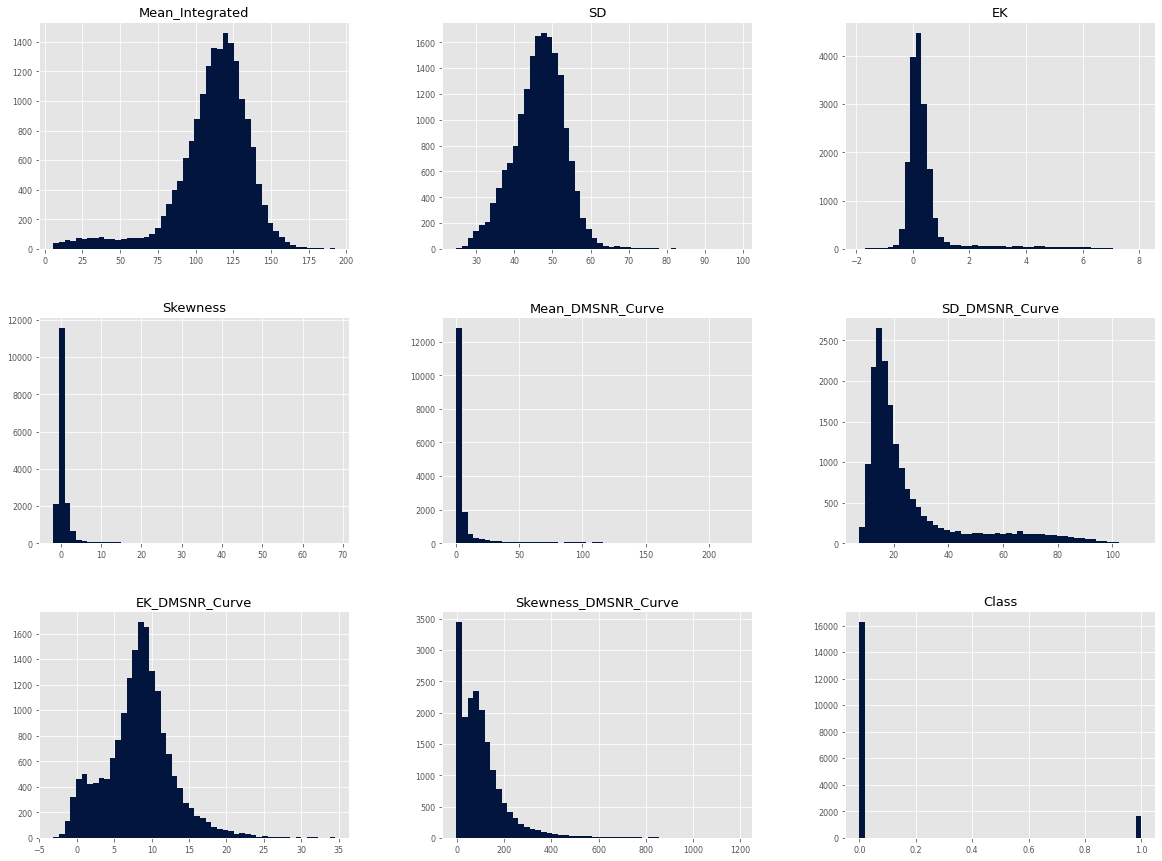

In [ ]:
dataset.hist(bins=50, figsize=(20,15), color= colors[0])
plt.show()

##Analisi statistica

Profilo integrato (Integrated Profile)

Questa curva sembra essere una distribuzione normale, che è simmetrica rispetto al valor medio e spessore regolare delle code.

1. Mean

La media è vicina al 50% (percentile) e il 25% e il 75% sono entro una deviazione standard dalla media. C'è una grande differenza tra min e max, quindi una deviazione standard maggiore.

2. Std. Dev.

Poiché la media è vicina al 50% e il 25% e il 75% sono entro meno di una deviazione standard dalla media, questi dati sono distribuiti normalmente. I valori max e min sono 3-4 deviazioni standard dalla media.

3. Excess Kurtosis

La maggior parte di questi dati (almeno il 75%) è inferiore alla media. Quindi la distribuzione a sinistra della media è più diffusa della destra. Ciò significa che le code del profilo integrato hanno generalmente le stesse dimensioni delle normali distribuzioni.

4. Skewness

La maggior parte di questi dati (sicuramente più del 75%) è inferiore alla media. Quindi la distribuzione a sinistra della media è più diffusa della destra. Quindi il profilo integrato non deve essere molto asimmetrica.

Curva DM-SNR

Questa curva sembra essere più distesa rispetto a una distribuzione normale e inclinata verso la destra della media.

1. Mean

La deviazione standard della media è molto alta, con valori superiori al 75% inferiori alla media. Quindi la media della maggior parte delle curve è piccola.

2. Std. Dev.

Molto asimmetrica.

3. Excess Kurtosis

Questa è normalmente distribuita poiché media = 50% (percentile) e ogni 25% è circa una deviazione standard. Tuttavia, questi valori sono alti, quindi la curva DM-SNR ha code più grosse rispetto alla distribuzione normale.

4. Skewness

Valori molto alti e deviazione standard elevata. Quindi la curva DM-SNR è molto asimmetrica.

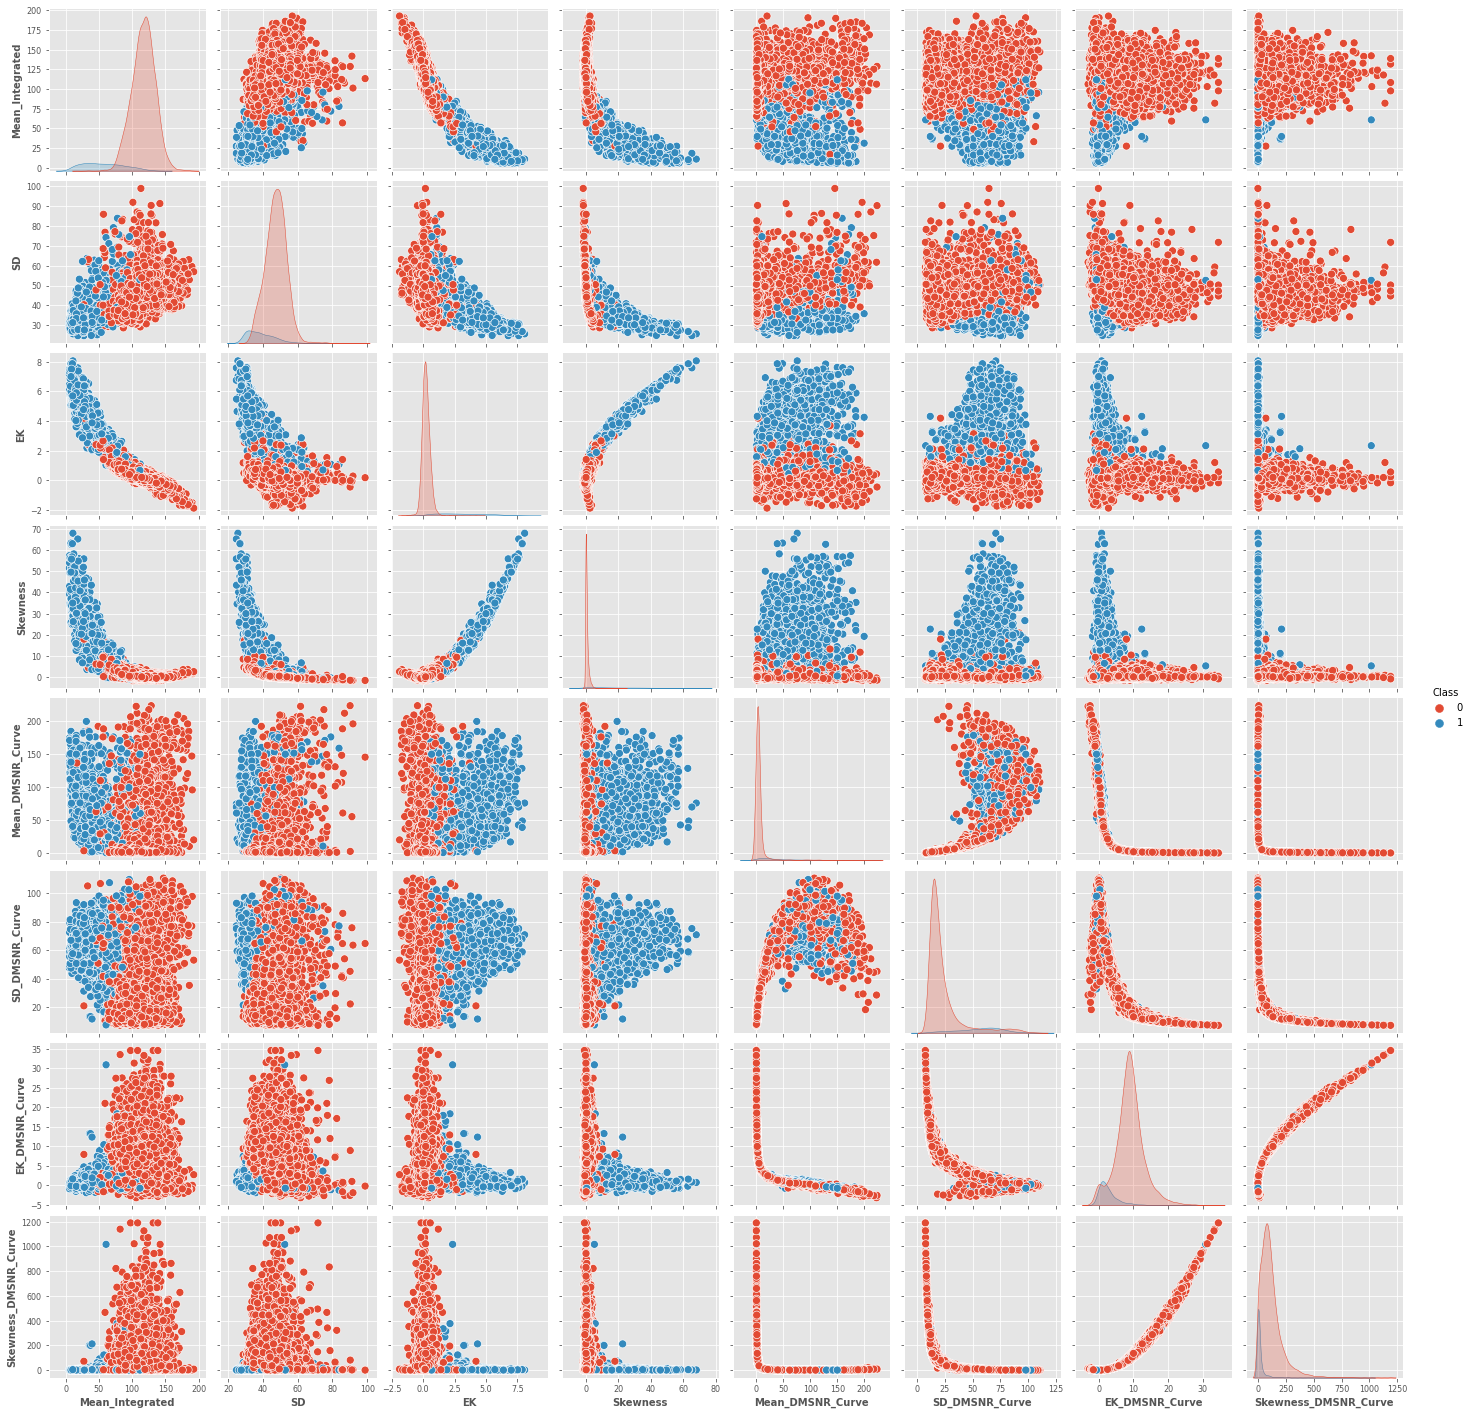

In [ ]:
df = dataset.copy()
sns.pairplot(data=df, hue="Class") #serve a vedere la correlazione tra le varie features

In [ ]:
not_pulsar, Pulsar= np.bincount(dataset['Class'])
total = Pulsar + not_pulsar
print('Examples:\n  Total: {}\n  Pulsar: {} ({:.2f}% of total)\n  Not Pulsar: {} ({:.2f}% of total)'.format(
    total, Pulsar, 100 * Pulsar / total, not_pulsar, 100 * not_pulsar / total))

Examples:
  Total: 17898
  Pulsar: 1639 (9.16% of total)
  Not Pulsar: 16259 (90.84% of total)


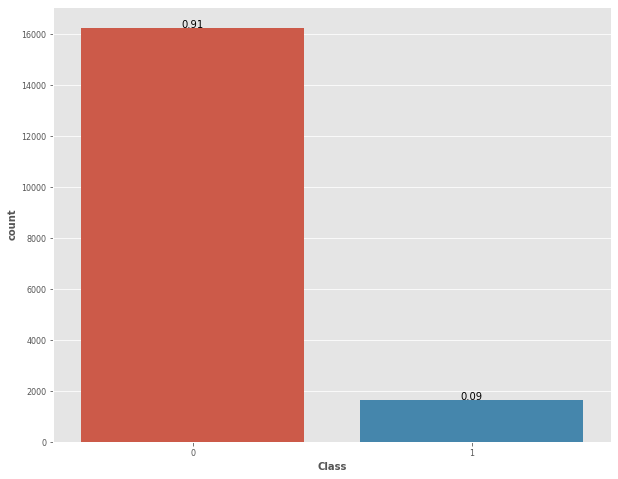

In [ ]:
# Visualizziamo i valori Target
total = float(len(dataset))
plt.figure(figsize = (10, 8))
ax = sns.countplot(x = "Class", data = dataset)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,height + 3,'{:1.2f}'.format(height/total),ha="center")

##Features selection

Poiché ci sono solo 8 features, non è necessaria la riduzione della dimensionalità.

Dalla matrice di correlazione (vedere pandas-profiling) vediamo che Excess Kurtosis e Skewness sono altamente correlati (sia per DM-SNR che per IP). Anche la loro correlazione con altre features è molto simile. Quindi possiamo eliminare una di queste. Inoltre, la media e la deviazione standard della curva DM-SNR sono altamente correlate. Quindi possiamo eliminare anche una di questi.

Eliminiamo: Excess Kurtosis del profilo integrato e la Skewness e la deviazione standard della curva DM-SNR.

In [ ]:
dataset_final = dataset.drop(['EK', 'Skewness_DMSNR_Curve', 'SD_DMSNR_Curve'], axis=1)
dataset_final

Mean_Integrated         SD  ...  EK_DMSNR_Curve  Class
0           140.562500  55.683782  ...        7.975532      0
1           102.507812  58.882430  ...       10.576487      0
2           103.015625  39.341649  ...        7.735822      0
3           136.750000  57.178449  ...        6.896499      0
4            88.726562  40.672225  ...       14.269573      0
...                ...        ...  ...             ...    ...
17893       136.429688  59.847421  ...       15.450260      0
17894       122.554688  49.485605  ...        2.945244      0
17895       119.335938  59.935939  ...        2.499517      0
17896       114.507812  53.902400  ...       10.007967      0
17897        57.062500  85.797340  ...       -1.597527      0

[17898 rows x 6 columns]

Dividiamo il dataset in una matrice delle features (X) e un vettore target (y)

In [ ]:
X,y=dataset_final.iloc[:,:-1].values, dataset_final.iloc[:,-1].values

In [ ]:
#funzioni utili
def display_scores(scores):
    print(f'scores: {scores}')
    print(f'mean: {scores.mean()}')
    print(f'Standard deviation: {scores.std()}')

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
 plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
 plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
 plt.grid(True)
 plt.xlabel('threshold')
 plt.legend()

def plot_decision_vs_recall(precisions, recalls, thresholds):
 plt.plot(recalls[:-1], precisions[:-1], "b")
 plt.grid(True)
 plt.xlabel('Recall')
 plt.ylabel('Precision')

def plot_roc_curve(fpr,tpr):
  plt.plot(fpr,tpr)
  plt.plot([0, 1], [0, 1], 'k--')
  #plt.scatter(fpr[150],tpr[150],color='r')
  plt.xlabel('false positive rate')
  plt.ylabel('true positive rate')
  plt.grid(True)

#Algoritmi usati

Logistic Regression

SVM

Decision Tree

Random Forest

AdaBoost Classifier

Neural Network

# **Logistic Regression**

La regressione logistica è un modello probabilistico discriminativo per la classificazione.

Facendo riferimento alla classificazione binaria, la regressione logistica modella la probabilità di un elemento di appartenere alla classe $C_1$ o $C_2$ facendo uso della funzione logistica:

$$p(C_1|\phi)=y(\vec{\phi})=\sigma(\vec{w}^T\vec{\phi})=\frac{1}{1+e^{-\vec{w}^T\vec{\phi}}}$$
con $p(C_2|\vec{\phi})=1-p(C_1|\vec{\phi})$.

Funzione logistica:

  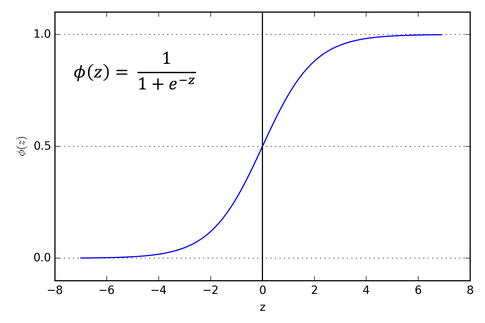



I vettori $\vec{\phi}$ sono delle funzioni base ovvero sono in generale delle trasformazioni non lineari dei valori di input originali $\vec{x}$. Queste funzioni sono utili nel caso in cui si pensa o si fa l'ipotesi che il dataset non è linearmente seprarabile nello spazio delle features originali. L'idea è quella di portare il problema in uno spazio con dimensionalità maggiore rispetto a quella iniziale, dove le classi diventano linearmente separabili. In questo nuovo spazio le classi possono essere separate da un iperpiano, se poi invece facciamo la trasformazione inversa tornando allo spazio delle features originali vedremo una superficie di separazione curva.

Per un dataset $(\phi_n,t_n)$ dove $t_n=(0,1)$ e $\vec{\phi_n}=\phi(\vec{x_n})$ la funzione likelihood può essere scritta
$$p(t|\vec{w})=\prod_{n=1}^{N}y_{n}^{t_n}(1-y_n)^{1-t_n}$$

La funzione costo è l'opposto del logaritmo della likelihood:
$$E(\vec{w})=-\sum_{n=1}^{N}[t_n ln(y_n)+(1-t_n)ln(1-y_n)]$$

**Ottimizzazione della funzione costo**

Per ottimizzare $E(\vec{w})$ esistono molti modi. Di seguito useremo l'algoritmo "Limited-memory Broyden–Fletcher–Goldfarb–Shanno" (**L-BFGS**).

Questo algoritmo è un algoritmo "Quasi-Newton" (una variante del metodo di Newton-Raphson). Ricordiamo che il metodo di Newton-Raphson aggiorna i pesi del modello nel seguente modo:

$$\vec{w}^{(new)}=\vec{w}^{(old)}-H^{-1}\vec{\nabla} E(\vec{w})   $$

Se chiamiamo $\vec{d}=-H^{-1}\vec{\nabla} E(\vec{w})$, vediamo che possiamo riscrivere tale espressione come

$$H\vec{d}=-\vec{\nabla} E(\vec{w})$$

e questo altro non è un sistema di equazioni lineari del tipo $A\vec{x}=\vec{b}$. L'incognita nel nostro caso è $\vec{d}$.

Se definiamo $$\Phi(\vec{d})=\frac{1}{2}\vec{d}^TH\vec{d}+\vec{d}^T\vec{\nabla} E$$ vediamo che il sistema di equazioni lineari è equivalente a risolvere il problema di ottimizzazione $\nabla \Phi(\vec{d})=0$.

Un modo per farlo è usare il classico metodo del gradient descent

$$\vec{d}^{(k+1)}=\vec{d}^{(k)}-\eta\vec{\nabla}\Phi(\vec{d}^{(k)})$$

dove la direzione di discesa è determinata dal gradiente della funzione costo calcolato nel punto $\vec{d}^{k}$. Quindi il percorso fatto da questo algoritmo è tale che $d^{k+1}$ è ottimale rispetto alla precedente direzione di discesa.

Il metodo di Newton è un metodo del secondo ordine e questo significa che vengono utilizzati i gradienti e la matrice Hessiana.
Questo metodo è computazionalmente costoso a causa dell'Hessiana. I metodi "Quasi-Newton" rimediano a questo problema approssimando la matrice Hessiana.

Il metodo L-BFGS si basa sul metodo BFGS. L'approssimazione BFGS dell'Hessiana può essere basata sull'intera storia dei gradienti, nel qual caso è indicata come BFGS, oppure può essere basata solo sugli m gradienti più recenti, nel qual caso è noto come BFGS a memoria limitata, abbreviato come L-BFGS. Il vantaggio di L-BFGS è che richiede solo il mantenimento degli m gradienti più recenti, dove m è solitamente compreso tra 5 e 20, che è un requisito di archiviazione molto inferiore rispetto a $n*(n+1)/2$ elementi necessari per memorizzare l'intero (triangolo) di una stima dell'Hessiana, come richiesto con BFGS, dove n è la dimensione del problema.

A differenza di (completo) BFGS, la stima dell'Hessiana non è mai esplicitamente formata o memorizzata in L-BFGS; piuttosto, i calcoli che sarebbero richiesti con la stima dell'Hessiana vengono eseguiti senza formarla esplicitamente. L-BFGS viene utilizzato al posto di BFGS per problemi molto grandi (quando n è molto grande), ma potrebbe non funzionare come BFGS. Pertanto, BFGS è preferito rispetto a L-BFGS quando è possibile soddisfare i requisiti di memoria di BFGS. D'altra parte, L-BFGS potrebbe non essere molto peggiore in termini di prestazioni rispetto a BFGS.

In [ ]:
#divisione in training set e test set
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42,stratify=y)

# istanziamo e addestriamo il modello
logistic_clf=Pipeline([
                             #('poly_features', PolynomialFeatures(degree=4)),
                             ('scaler',StandardScaler()),
                             ('logistic',LogisticRegression(solver='lbfgs',class_weight='balanced'))
                             ])
logistic_clf.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logistic', LogisticRegression(class_weight='balanced'))])

Valutiamo le prestazioni del modello sul training set

In [ ]:
predict_train=logistic_clf.predict(X_train)
proba_train=logistic_clf.predict_proba(X_train)[:,1]
print(f'AUC_train:{roc_auc_score(y_train,proba_train)}')

AUC_train:0.9656235054876254


Valutiamo le prestazioni del modello usando la cross validation

In [ ]:
# cross validation per verificare le prestazioni del modello base, in seguito faremo un tuning dei parametri per cercare di migliorarlo.
scores=cross_val_score(logistic_clf,X_train,y_train,cv=5,scoring='roc_auc')
display_scores(scores)

scores: [0.95889405 0.97402957 0.96166234 0.95851912 0.97295685]
mean: 0.9652123845866327
Standard deviation: 0.006856288534077584


Le prestazioni son simili e possiamo essere fiduciosi del fatto che il modello non è andato in overfitting e generalizza bene.

Ricordiamo però che i risultati ottenuti vengono dall'assunzione di un dataset linearmente separabile nello spazio delle features. Proviamo a far cadere questa assunzione implementando delle funzioni base polinomiali di diverso grado e vediamo se il modello migliora o meno.

In [ ]:
degrees=[1,2,3,4,5,6] #valori dei gradi su cui iterare
mean_score_fold=[] #per ogni grado appendiamo la AUC media
std_score_fold=[] #deviazione standard relativa agli elementi della lista mean_score_fold
score_train=[] # valore AUC  sul training set, uno per ogni grado
for degree in degrees:

    #istanziamo il modello
    bestlogistic_clf=Pipeline([
                             ('poly_features', PolynomialFeatures(degree=degree,include_bias=False)),
                             ('scaler',StandardScaler()),
                             ('logistic',LogisticRegression(solver='lbfgs',class_weight='balanced', max_iter=1000))
                             ])

    #per ogni grado facciamo una cross validation con cv=5
    scores=cross_val_score(bestlogistic_clf,X_train,y_train,scoring='roc_auc',cv=5) #resituisce 5 valori di AUC, uno per fold
    mean_score_fold.append(scores.mean())
    std_score_fold.append(scores.std())


    bestlogistic_clf.fit(X_train,y_train)
    predict_train=bestlogistic_clf.predict(X_train)
    proba_train=bestlogistic_clf.predict_proba(X_train)[:,1]
    score_train.append(roc_auc_score(y_train,proba_train))

    print(f'Degree: {degree}')
    print(f'Scores: {scores}')
    print(f'Mean: {scores.mean()}')
    print(f'Standard deviation: {scores.std()}')
    print(f'AUC_train: {roc_auc_score(y_train,proba_train)}')
    print('===================================================')

Degree: 1
Scores: [0.95889405 0.97402957 0.96166234 0.95851912 0.97295685]
Mean: 0.9652123845866327
Standard deviation: 0.006856288534077584
AUC_train: 0.9656235054876254
Degree: 2
Scores: [0.97049669 0.97782723 0.97255483 0.96732565 0.97964904]
Mean: 0.9735706889022406
Standard deviation: 0.004572668394202171
AUC_train: 0.9744270858748582
Degree: 3
Scores: [0.97365721 0.97749675 0.97514327 0.96878765 0.98076569]
Mean: 0.9751701152728106
Standard deviation: 0.003993722759303235
AUC_train: 0.9764820104662116
Degree: 4
Scores: [0.97414625 0.97753305 0.9741652  0.96896033 0.98182861]
Mean: 0.9753266879348781
Standard deviation: 0.004252435629049995
AUC_train: 0.9774348979589179
Degree: 5
Scores: [0.96289264 0.97696569 0.97150225 0.96897568 0.9820646 ]
Mean: 0.9724801745731279
Standard deviation: 0.006589988014518403
AUC_train: 0.9783008389684484
Degree: 6
Scores: [0.96624303 0.97484718 0.96833881 0.96910998 0.98203966]
Mean: 0.9721157316684446
Standard deviation: 0.005722473466893738
AUC_

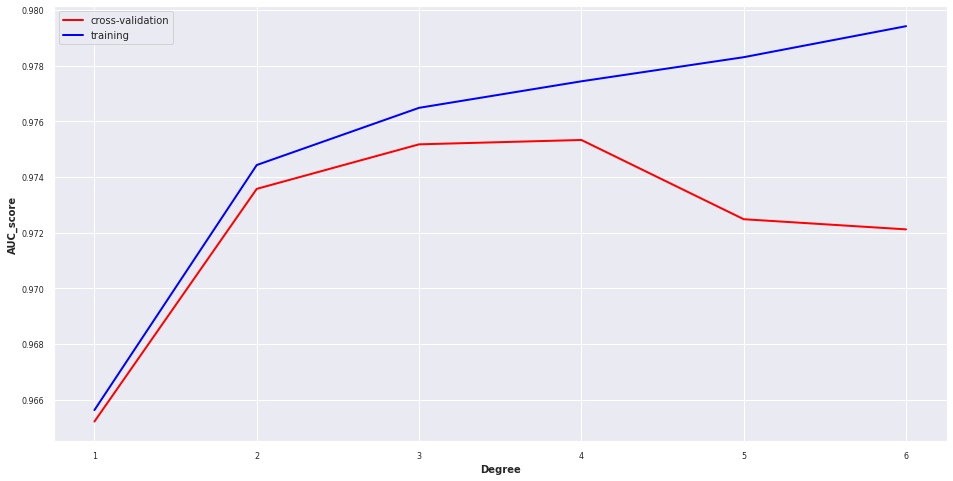

In [ ]:
def plot_AUC_vs_degree(deg,fold,train):
    plt.plot(deg,fold,color='red',label='cross-validation')
    plt.plot(deg,train,color='blue',label='training')
    plt.legend()
    plt.grid(True)
    plt.xlabel('Degree')
    plt.ylabel('AUC_score')
plot_AUC_vs_degree(degrees,mean_score_fold,score_train)
plt.show()

Passando da un modello lineare nello spazio delle features originale (grado dei polinomi=1), ad un modello che fa uso di funzioni base polinomiali, vediamo come la prestazione in termini di AUC aumenta notevolmente (per grado dei polinomi= 2 e 3).

Per valori di grado compresi tra 3 e 4 le prestazioni del modello sulle fold di test resta crica costante. La differenza sta di quanto vanno in overfitting: più aumentiamo il grado, più il modello va in overfitting.

Per valori di grado maggiori di 4 il modello va sempre più in overfitting ma la situazione è peggiorata dal fatto che adesso cominciamo a peggiorare anche le prestazioni sulle fold di test. Questo è sicuramente un range da scartare.

Per le considerazioni precedenti riteniamo accettabili funzioni base di grado 3. Tale grado permette infatti di avere un buon aumento sulle fold di test rispetto al grado 2 e l'overfitting resta tutto sommato limitato.

In [ ]:
logistic_model=Pipeline([
                             ('poly_features', PolynomialFeatures(degree=3, include_bias=False)),
                             ('scaler',StandardScaler()),
                             ('logistic',LogisticRegression(solver='lbfgs',class_weight='balanced', max_iter=1000))
                             ])
logistic_model.fit(X_train,y_train)

Pipeline(steps=[('poly_features',
                 PolynomialFeatures(degree=3, include_bias=False)),
                ('scaler', StandardScaler()),
                ('logistic',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

Valutazione sul training set

In [ ]:
predict_train=logistic_model.predict(X_train)
proba_train=logistic_model.predict_proba(X_train)[:,1]
#print(proba_train1[:10])
#print(predict_train)
#print(proba_train)
print(f'AUC_train:{roc_auc_score(y_train,proba_train)}')

AUC_train:0.9764820104662116


Valutazione cross-validation

In [ ]:
y_score=cross_val_predict(logistic_model,X_train,y_train,cv=5,method='predict_proba')[:,1]
print(y_score[:20]) #printiamo i primi 20 risultati
scores=cross_val_score(logistic_model,X_train,y_train,cv=5,scoring='roc_auc')
display_scores(scores)

[0.03743069 0.16857278 0.13172883 0.00149833 0.04771387 0.0903931
 0.06079256 0.00886291 0.04988011 0.096361   0.07003761 0.02307911
 0.14242299 0.01290952 0.20487472 0.99727013 0.00485937 0.22635056
 0.0047822  0.04293522]
scores: [0.97365721 0.97749675 0.97514327 0.96878765 0.98076569]
mean: 0.9751701152728106
Standard deviation: 0.003993722759303235


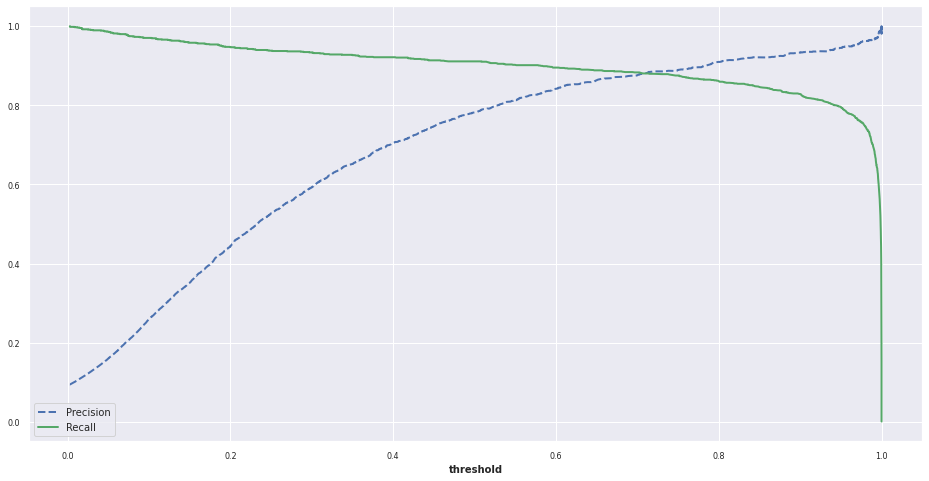

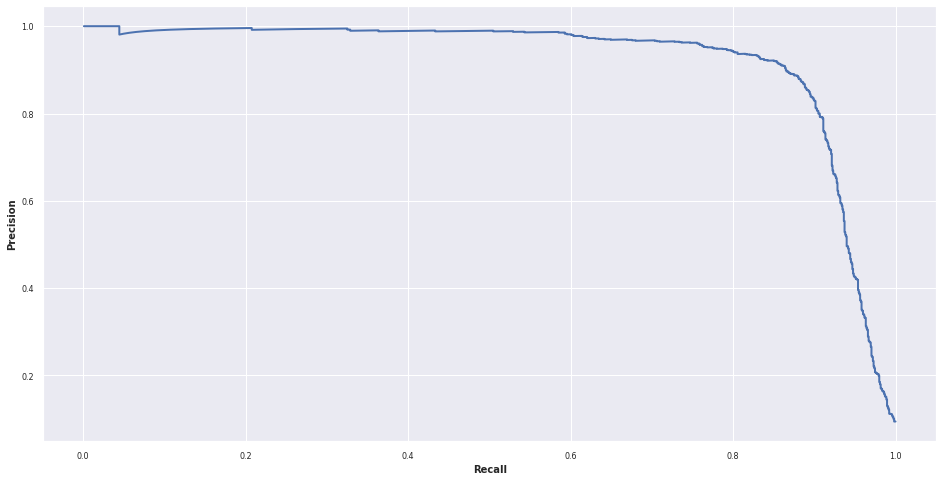

In [ ]:
#andamenti di precision e recall
precisions,recalls,thresholds=precision_recall_curve(y_train,y_score)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

plot_decision_vs_recall(precisions, recalls, thresholds)
plt.show()

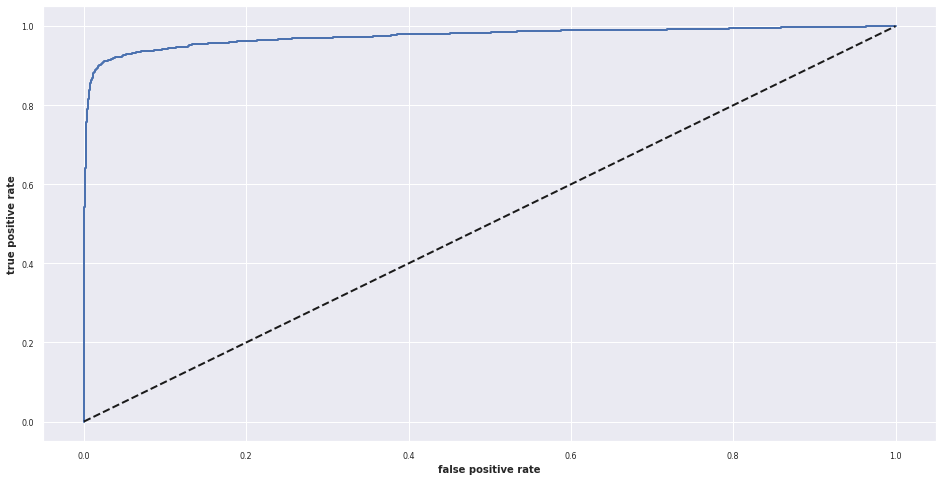

In [ ]:
fpr,tpr,thresholds=roc_curve(y_train,y_score)

plot_roc_curve(fpr,tpr)
plt.show()

Adesso possiamo valutare il modello sul test set

In [ ]:
threshold=0.7 #valore della threshold scelto come esempio per plottare la matrice di confusione
proba_test=logistic_model.predict_proba(X_test)[:,1]
predict_test=np.multiply(logistic_model.predict_proba(X_test)[:,1]>threshold,1) #vettore binario a seconda che la probabilità sia maggiore o minore di una threshold da scegliere
print(f'AUC_test:{roc_auc_score(y_test,proba_test)}')

AUC_test:0.9700238669053356


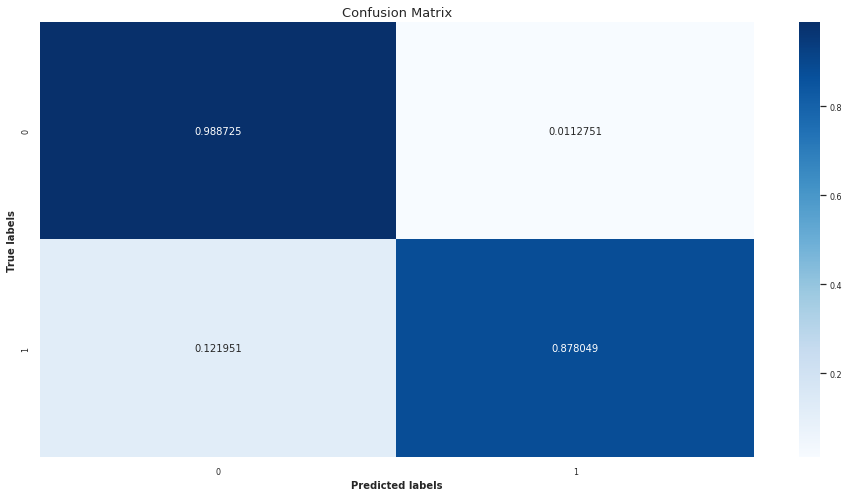

In [ ]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test,predict_test,normalize='true'), cmap=plt.cm.Blues, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1']);

# **Decision Tree**

Il Decision Tree è un algoritmo di Machine Learning non parametrico.

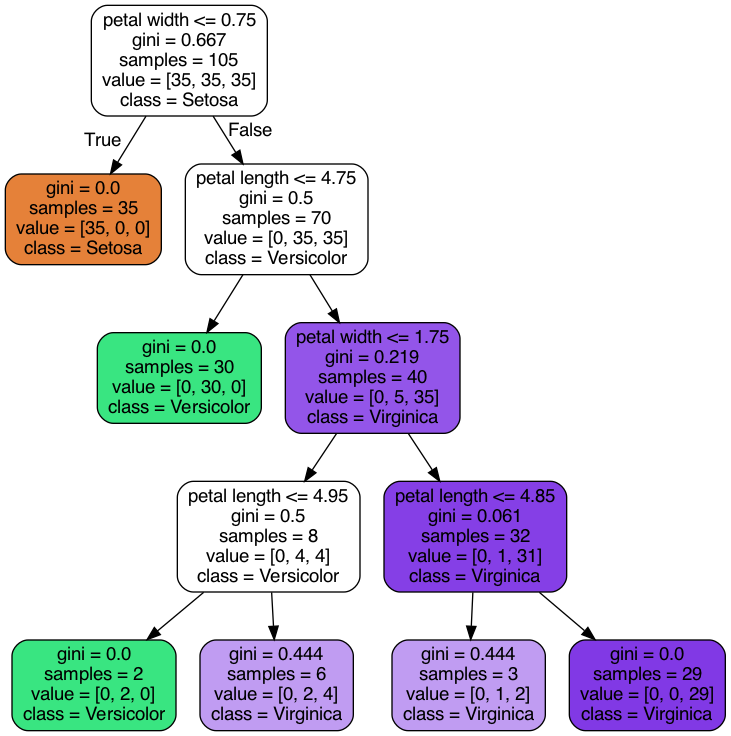

Il decision tree è formato da nodi. I nodi che hanno una features su cui dividersi sono chiamati nodi interni. Il primo nodo interno in alto è chiamato radice. I nodi finali in cui facciamo le previsioni della classe sono chiamati nodi foglia. I nodi interni hanno tutti dei nodi sotto di loro, che chiamiamo nodi figlio.

Quando costruiamo il decision tree, non scegliamo casualmente su quale features fare lo split per prima. Vogliamo iniziare scegliendo la funzione con più potere predittivo.

Per determinare su quale feature e soglia dovremmo effettuare lo split, dobbiamo assegnare uno score a ogni possibile divisione in modo da poter scegliere la divisione con lo score più alto. Il nostro obiettivo sarebbe quello di dividere perfettamente i dati. Quindi selezioniamo la feature e la soglia con la misurà di impurità minima. Un nodo foglia è puro (ovvero ha impurtà minima) quando tutti i suoi elementi appartengono alla stessa classe.

#Misura di impurità

Sia data una variabile casuale discreta, con dominio $\lbrace a_1 ,..., a_k \rbrace$, con distribuzione di probabilità, sul dominio, data dall'insieme $p= \left( p_1 ,..., p_k \right)$. Allora, una misura di impurità $\phi : p \rightarrow \mathbb{R}$ ha le seguenti proprietà:

1) $\phi (p) \geq 0$ per tutti i possibili valori di p

2) $\phi (p)$ è minima se esiste $\textit{i}$, con $1 \leq i \leq k$, tale che $p_i =1$

3) $\phi (p)$ è massima se $p_i = \frac{1}{k}$ per ogni i

4) $\phi (p) = \phi (p^{\prime})$ per ogni $p^{\prime}$ derivanti da una permutazione di $p$

5) $\phi (p)$ è differenziabile ovunque

Nel nostro caso consideriamo la classe di ogni elemento in $S$, dove $S$ è l'insieme degli elemeti della regione che stiamo considerando.

Per ogni insieme di elementi $S$, il vettore di probabilità associato ad $S$ può essere definito come $p= \left( \frac{\vert S_1 \vert}{\vert S \vert} ,..., \frac{\vert S_k \vert}{\vert S \vert} \right)$, dove $S_h \subseteq S $ è l'insieme di elementi di $S$ appartenenti alla classe $h$.

Data una funzione $f : S \rightarrow \lbrace 1 ,..., r \rbrace$, sia $s_i = \left\lbrace x \in S \vert f(x) = i \right\rbrace $. Allora la qualità dello split di $S$ rispetto a $r$ è data da:
$$\Delta_{\phi} \left( S,f \right) = \phi (p_S) - \sum_{i=1}^{r} p_i \hspace{1mm} \phi (p_{s_i})$$

In questo codice, per calcolare la purezza useremo due tipi di misura: l'indice di gini e l'entropia.

#Entropia
Per ogni insieme $S$ di elementi, definiamo
$$ H_s = -\sum_{i=1}^{k} \frac{\vert S_i \vert}{\vert S \vert} \hspace{1mm} log_2 \left( \frac{\vert S_i \vert}{\vert S \vert} \right) $$
l'entropia di $S$.

L'information gain rispetto a una funzione di partizione $f$ è la diminuzione dell'entropia da $S$ alla somma dell'entropia di $s_i$ (pesata dalla probabilità associata)
$$ IG(S, f) = H_S - \sum_{j=1}^{r} \frac{\vert s_j \vert}{\vert S \vert} H_{s_j}$$

# Indice di Gini

L'indice di Gini è una misura di quanto sia puro un insieme.

L'indice di Gini è definito come
$$ G_S = 1 - \sum_{i=1}^{k} \left( \frac{\vert S_i \vert}{\vert S \vert} \right)^2$$

Usando l'indice di Gini come misura dell'impurità, la bontà dello split è data dal Gini gain, definito come segue.

Il Gini gain rispetto a una funzione di partizione $f$ è la diminuzione dell'indice di Gini da $S$ alla somma pesata dell'indice di Gini di $s_i$
$$ GG(S, f) = G_S - \sum_{j=1}^{r} \frac{\vert s_j \vert}{\vert S \vert} G_{s_j} $$

# Pruning

I decision tree sono incredibilmente inclini all'overfitting. Poiché possono continuare ad avere nodi aggiuntivi nell'albero, il modello può davvero scavare a fondo nelle specifiche del training set. A seconda dei dati, ciò potrebbe comportare un modello che non cattura la vera natura dei dati e non generalizza.

Per risolvere questi problemi, facciamo ciò che viene chiamato pruning the tree.

Esistono due tipi di pruning: pre-pruning e post-pruning. Nel pre-pruning, abbiamo delle regole su quando smettere di costruire l'albero, quindi smettiamo di costruire prima che l'albero sia troppo grande. Nel post-pruning costruiamo l'intero albero, poi lo esaminiamo e decidiamo quali foglie rimuovere per rimpicciolirlo.

Ci concentreremo sulle tecniche di pre-pruning. Abbiamo alcune opzioni su come limitare la crescita degli alberi. Ecco alcune tecniche di pre-pruning utilizzate:

• 𝐌𝐚𝐱 𝐝𝐞𝐩𝐭𝐡 : far crescere l'albero solo fino a una certa profondità (o altezza dell'albero)

• 𝐋𝐞𝐚𝐟 𝐬𝐢𝐳𝐞 : non dividere un nodo se il numero di elementi in quel nodo è inferiore a una soglia

• 𝐍𝐮𝐦𝐛𝐞𝐫 𝐨𝐟 𝐥𝐞𝐚𝐟 𝐧𝐨𝐝𝐞𝐬 : limita il numero totale di nodi foglia consentiti nell'albero

# Vantaggi e svantaggi del decision tree

**Computazione**: un decision tree è molto costoso dal punto di vista computazionale da costruire.

La previsione con un decision tree, d'altra parte, è molto economica dal punto di vista computazionale. Devi solo porre una serie di domande sì/no sul datapoint per arrivare alla previsione.

**Performance**: i decision tree possono funzionare discretamente bene a seconda dei dati, sebbene siano inclini all'overfitting.
Per porre rimedio ai problemi di overfitting, i decision tree generalmente richiedono un processo di tuning per ottenere il miglior modello possibile.

I decision tree spesso richiedono lavoro per essere alla pari con le prestazioni di altri modelli senza ottimizzazione.

**Interpretability**: I decision tree sono facilmente interpretabili.

In [ ]:
dt_clf = DecisionTreeClassifier(class_weight='balanced', random_state=42)

#divisione in training set e test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [ ]:
criterio=['gini', 'entropy']
for crit in criterio:
    dt_1 = DecisionTreeClassifier(criterion=crit, class_weight='balanced', random_state=42)
    dt_1.fit(X_train, y_train)
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    print('AUC %s:' %(crit))
    print(cross_val_score(dt_1, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1))

AUC gini:
[0.89580541 0.89446206 0.8879174  0.88792009 0.89010349 0.87441052
 0.89709827 0.90533163 0.88989724 0.89382468 0.91130884 0.890311
 0.8929472  0.8813833  0.8726631 ]
AUC entropy:
[0.89559828 0.89448499 0.89707534 0.89164128 0.90345047 0.88531508
 0.90142317 0.91295178 0.9003749  0.90431578 0.92244545 0.89118973
 0.89270459 0.88793352 0.87528588]


Cerchiamo i parametri ottimali

In [ ]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 15, 30],
    'min_samples_leaf': [50, 200, 300],
    'max_leaf_nodes': [50, 100, 400]}

dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
gs = GridSearchCV(dt, param_grid, scoring='roc_auc', cv=cv, n_jobs=-1)

gs.fit(X_train, y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=42),
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 15, 30],
                         'max_leaf_nodes': [50, 100, 400],
                         'min_samples_leaf': [50, 200, 300]},
             scoring='roc_auc')

In [ ]:
print("best params:", gs.best_params_)
print("best score:", gs.best_score_)

best params: {'criterion': 'gini', 'max_depth': 15, 'max_leaf_nodes': 50, 'min_samples_leaf': 200}
best score: 0.9594698273699988


In [ ]:
gs.best_estimator_

DecisionTreeClassifier(class_weight='balanced', max_depth=15, max_leaf_nodes=50,
                       min_samples_leaf=200, random_state=42)

Valutiamo il miglior decision tree sul training set

In [ ]:
best_dt= gs.best_estimator_ #il miglior modello trovato tramite Grid_Search

y_score = cross_val_predict(best_dt,X_train,y_train,cv=5, method='predict_proba')[:, 1]
print(y_score[:20]) #printiamo i primi 20 risultati
cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
scores=cross_val_score(best_dt,X_train,y_train,cv=cv,scoring='roc_auc')
display_scores(scores)

[0.         0.23380159 0.05010788 0.         0.         0.02978882
 0.25949594 0.         0.         0.         0.4153711  0.
 0.19621641 0.         0.08914304 0.95098818 0.         0.19933875
 0.03555611 0.        ]
scores: [0.95922295 0.958454   0.96821464 0.95212143 0.95589155]
mean: 0.9587809150039437
Standard deviation: 0.005329062805983949


Precision, recall e curva ROC

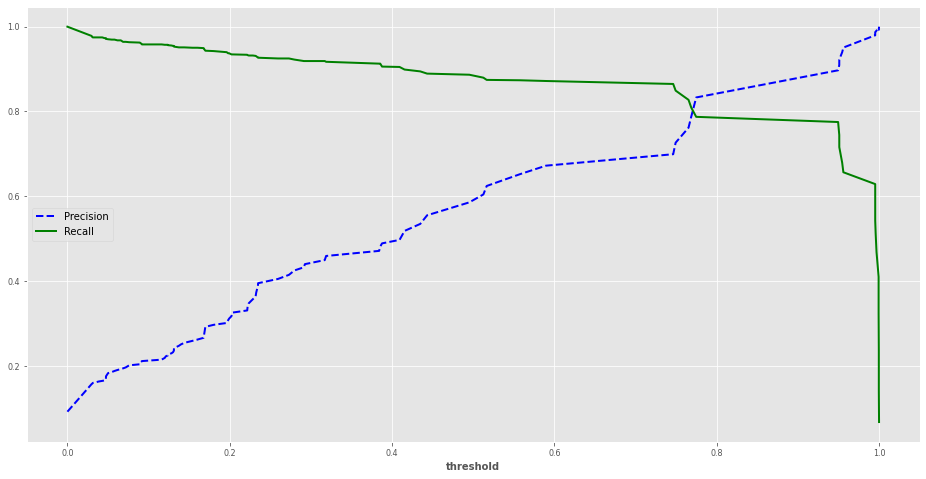

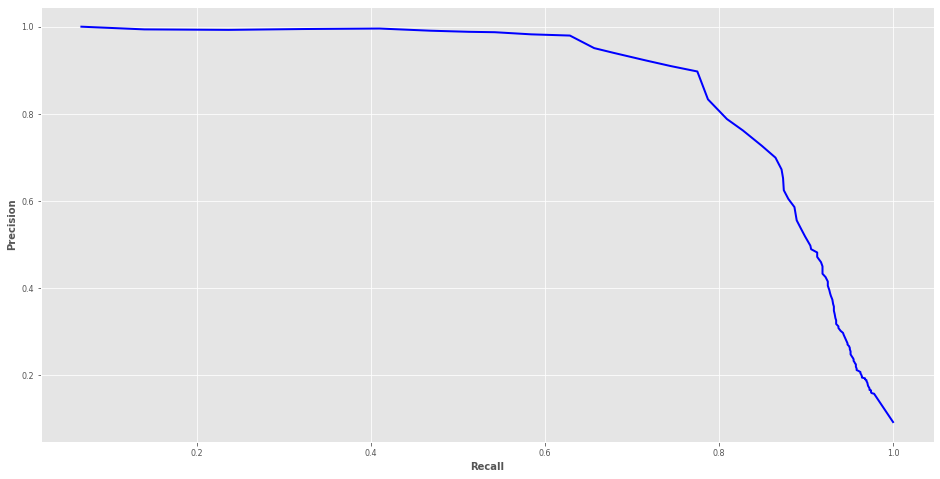

In [ ]:
#andamenti di precision e recall
precisions,recalls,thresholds=precision_recall_curve(y_train,y_score)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

plot_decision_vs_recall(precisions, recalls, thresholds)
plt.show()

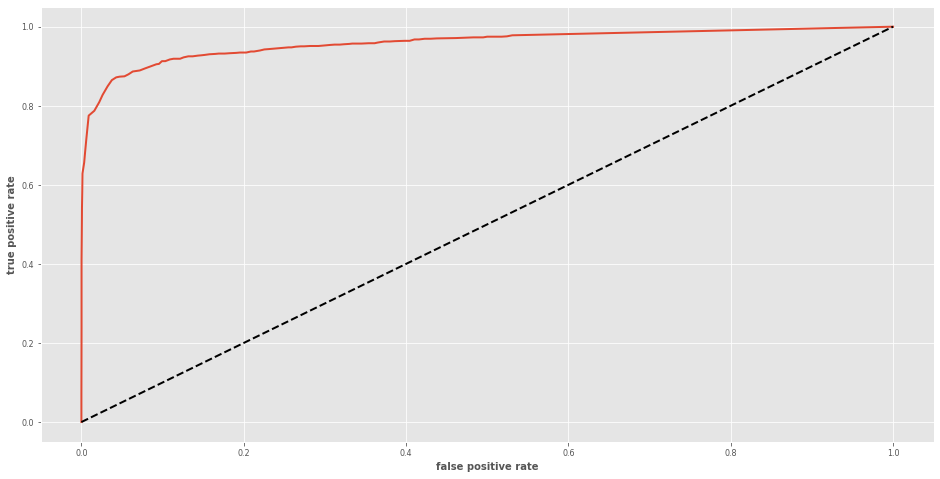

In [ ]:
fpr,tpr,thresholds=roc_curve(y_train,y_score)

plot_roc_curve(fpr,tpr)
plt.show()

Valutiamo l'algoritmo sul test set

In [ ]:
threshold=0.8 #valore della threshold scelto come esempio per plottare la matrice di confusione
y_pred_test=best_dt.predict_proba(X_test)[:,1]
print(f'AUC_test:{roc_auc_score(y_test,y_pred_test)}')

AUC_test:0.9570314453144532


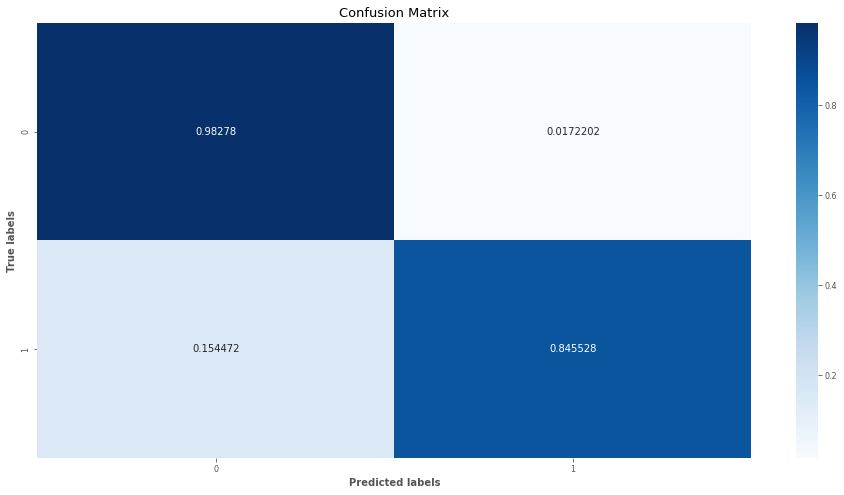

In [ ]:
y_dt_th= y_pred_test > threshold

ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test,y_dt_th,normalize='true'), cmap=plt.cm.Blues, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1']);

Plottiamo l'albero

In [ ]:
#salviamo in locale l'immagine dell'albero
dot_file = tree.export_graphviz(best_dt,
                     feature_names = dataset_final.columns[:-1],
                     filled = True)
graph = graphviz.Source(dot_file)
graph.render(filename='tree', format='jpg', cleanup=True, view=True) #view=‘True’ apre il file jpg

'tree.jpg'

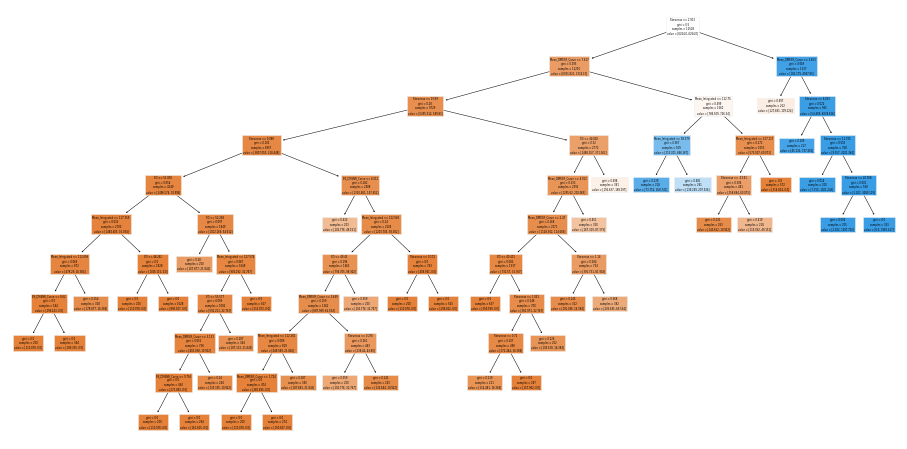

In [ ]:
tree.plot_tree(best_dt,feature_names = dataset_final.columns[:-1],filled = True); #è meglio l'immagine salvata in locale

# **Random Forest**

Il Random Forest è un esempio di ensamble perché usa più modelli di machine learning per costruire un singolo modello.

I decision trees hanno una varianza molto alta.

Il random forest prende i vantaggi del decision tree diminuendo la varianza.

Vediamo su cosa si basa questo modello.

#Metodi ensemble

Nei metodi ensemble viene usato un insieme di classificatori detti weak learners.

Ci sono due metodi per combinare insieme i vari modelli:

1) **bagging**: si allena un comitato di $L$ diversi modelli e si effettua la predizione con ognuno dei modelli. Successivamente si combinano le $L$ predizioni, dei vari modelli, tipicamente o con una media (regressione) o per votazione (classificazione).

2) **boosting**: i modelli sono istanziati in maniera non indipendente l'uno dall'altro. Il modo in cui viene instanziato l'i-esimo modello dipende dall'efficacia del (i-1)-esimo modello. Si ha un addestramento sequenziale. La predizione viene fatta combinando insieme le relative predizioni.

#Bagging

Il bagging usa tipacamente classificatori con elevata varianza.

Il bagging può essere visto come un metodo finalizzato a diminuire la varianza della classificazione adottata.

Il bagging fa riferimento al metodo di **bootstrap**.

Il bootstrap è una tecnica di resampling usata in statistica.

Un bootstrapped sample è un campione casuale di dati, dove i dati vengono selezionati casualmente, con replacement, dal dataset di partenza per creare, nel nostro caso, un dataset della stessa dimensione. La selezione casuale con replacement significa che possiamo scegliere lo stesso dato più volte.

Dato un training set il bagging media le predizioni fatte da classificatori, dello stesso tipo, su una collezione di bootstrapped samples. Alla fine, per classificare un input $x$, si prende la classe con più voti tra tutti i classificatori. Nel caso della regressione, il valore predetto è dato dalla media delle predizioni.

Il random forest è un'applicazione del bagging a un insieme (random) di decision trees.

In un decision tree di una random forest, in ogni nodo, selezioniamo casualmente un sottoinsieme delle features da considerare. Questo ci porterà a scegliere una feature buona, ma non la migliore, su cui splittare ad ogni passaggio.

Una scelta standard per il numero di features da considerare ad ogni suddivisione è la radice del numero di features.

In [ ]:
rf_clf = RandomForestClassifier(class_weight='balanced', random_state=42)

#divisione in training set e test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

rf_clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

Valutiamo il modello con la cross-validation

In [ ]:
criterio=['gini', 'entropy']
for crit in criterio:
    rf_1 = RandomForestClassifier(criterion=crit, class_weight='balanced', random_state=42)
    rf_1.fit(X_train, y_train)
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    print('AUC %s:' %(crit))
    print(cross_val_score(rf_1, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1))

AUC gini:
[0.96573577 0.97474784 0.96765397 0.96110928 0.95339924 0.95394423
 0.95557041 0.97352525 0.96942176 0.95819103 0.96695645 0.95994976
 0.97628658 0.95359207 0.95420699]
AUC entropy:
[0.96396853 0.97054138 0.9687457  0.9554023  0.95989094 0.95896501
 0.96002044 0.97282895 0.97072068 0.96552022 0.96833246 0.96077501
 0.97303049 0.95011166 0.95828409]


Cerchiamo i parametri ottimali

In [ ]:
n_estimators = list(range(1, 121))

param_grid = {
    'criterion': ['gini'],
    'n_estimators': n_estimators}

rf = RandomForestClassifier(class_weight='balanced', random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs_rf1 = GridSearchCV(rf, param_grid, scoring='roc_auc', cv=cv, n_jobs=-1)

gs_rf1.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini'],
                         'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18, 19, 20, 21,
                                          22, 23, 24, 25, 26, 27, 28, 29, 30, ...]},
             scoring='roc_auc')

In [ ]:
print("best params:", gs_rf1.best_params_)
print("best score:", gs_rf1.best_score_)
gs_rf1.best_estimator_

best params: {'criterion': 'gini', 'n_estimators': 99}
best score: 0.9645953636564414


RandomForestClassifier(class_weight='balanced', n_estimators=99,
                       random_state=42)

In [ ]:
n_estimators = list(range(1, 121))

param_grid = {
    'criterion': ['entropy'],
    'n_estimators': n_estimators}

rf = RandomForestClassifier(class_weight='balanced', random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs_rf2 = GridSearchCV(rf, param_grid, scoring='roc_auc', cv=cv, n_jobs=-1)

gs_rf2.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['entropy'],
                         'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18, 19, 20, 21,
                                          22, 23, 24, 25, 26, 27, 28, 29, 30, ...]},
             scoring='roc_auc')

In [ ]:
print("best params:", gs_rf2.best_params_)
print("best score:", gs_rf2.best_score_)
gs_rf2.best_estimator_

best params: {'criterion': 'entropy', 'n_estimators': 119}
best score: 0.9644212559385446


RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       n_estimators=119, random_state=42)

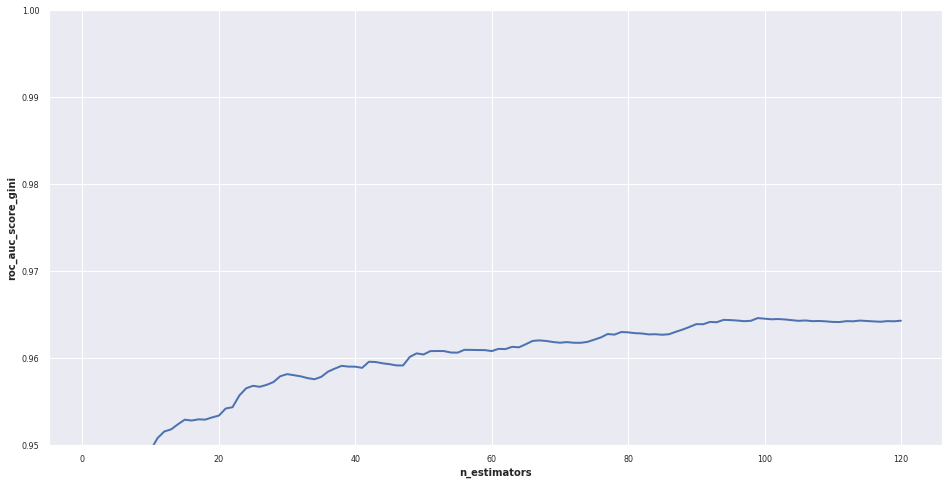

In [ ]:
scores_auc_g = gs_rf1.cv_results_['mean_test_score']
plt.plot(n_estimators, scores_auc_g)
plt.xlabel("n_estimators")
plt.ylabel("roc_auc_score_gini")
#plt.xlim(0, 100)
plt.ylim(0.95, 1)
plt.show()

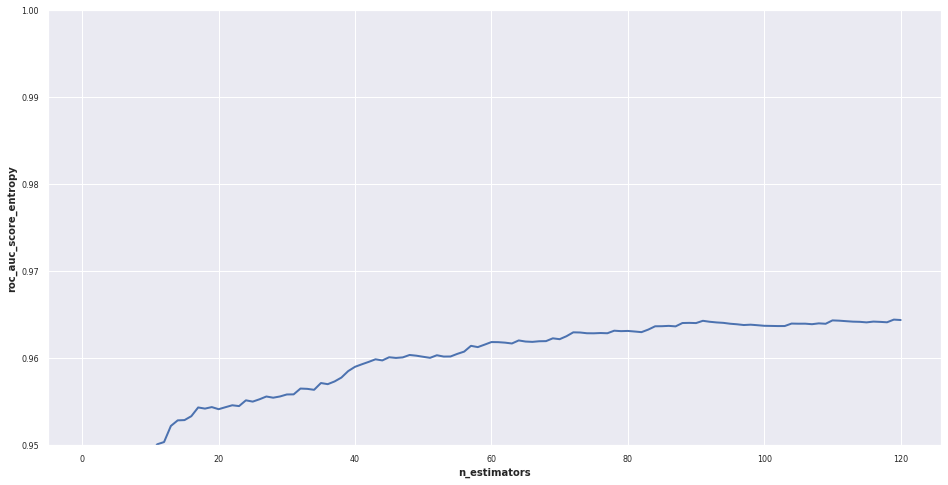

In [ ]:
scores_auc_e = gs_rf2.cv_results_['mean_test_score']
plt.plot(n_estimators, scores_auc_e)
plt.xlabel("n_estimators")
plt.ylabel("roc_auc_score_entropy")
#plt.xlim(0, 100)
plt.ylim(0.95, 1)
plt.show()

Prendiamo come miglior modello quello con criterio gini e 99 alberi perché abbiamo una performance migliore con un minor numero di alberi (minor complessità). Naturalmente, usando i due grafici sopra , possiamo anche scegliere anche altri modelli. Ad esempio, vediamo che anche un modeelo con 60 alberi (sia con gini che con l'entropia) è un buon modello, dato che ha una parformance molto vicina alla miglior perfomance (c'è una differenza di 0.04) e la complessità è minore.

Valutiamo il miglior modello sul training set

In [ ]:
best_rf= gs_rf1.best_estimator_ #il miglior modello trovato tramite Grid_Search

y_score_rf = cross_val_predict(best_rf,X_train,y_train,cv=5, method='predict_proba')[:, 1]
print(y_score_rf[:20]) #printiamo i primi 20 risultati
scores_rf=cross_val_score(best_rf,X_train,y_train,cv=5,scoring='roc_auc')
display_scores(scores_rf)

[0.         0.02020202 0.         0.         0.         0.
 0.         0.         0.         0.         0.01010101 0.01010101
 0.04040404 0.         0.06060606 0.97979798 0.         0.01010101
 0.         0.        ]
scores: [0.96244676 0.97264079 0.95542332 0.94440565 0.97037245]
mean: 0.9610577914902934
Standard deviation: 0.010314058878553219


Precision, recall e curva ROC

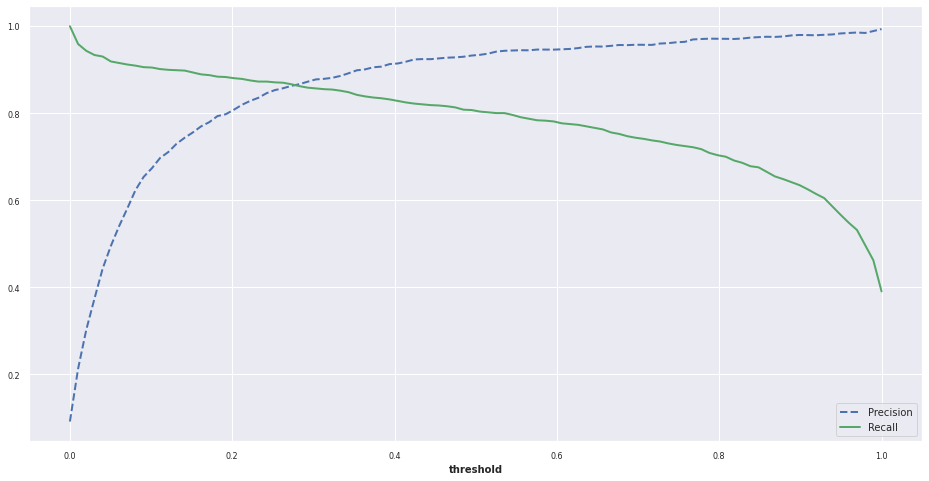

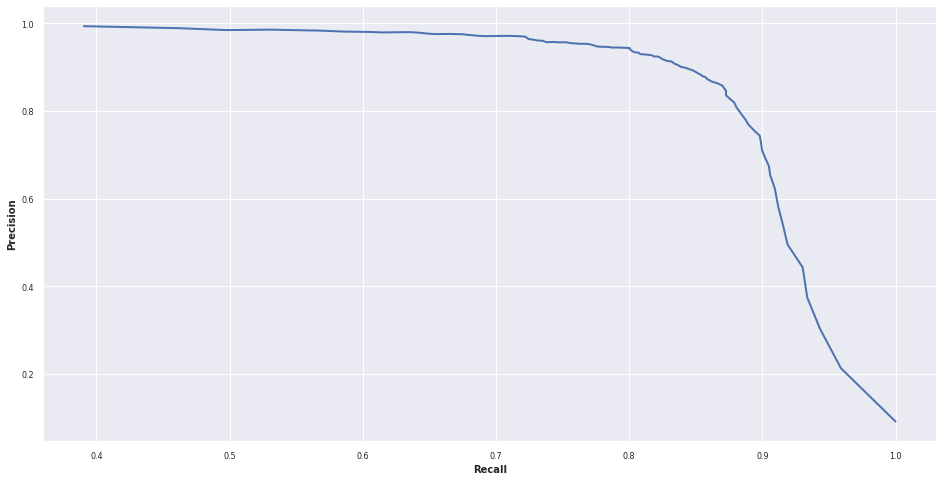

In [ ]:
#andamenti di precision e recall
precisions,recalls,thresholds = precision_recall_curve(y_train,y_score_rf)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

plot_decision_vs_recall(precisions, recalls, thresholds)
plt.show()

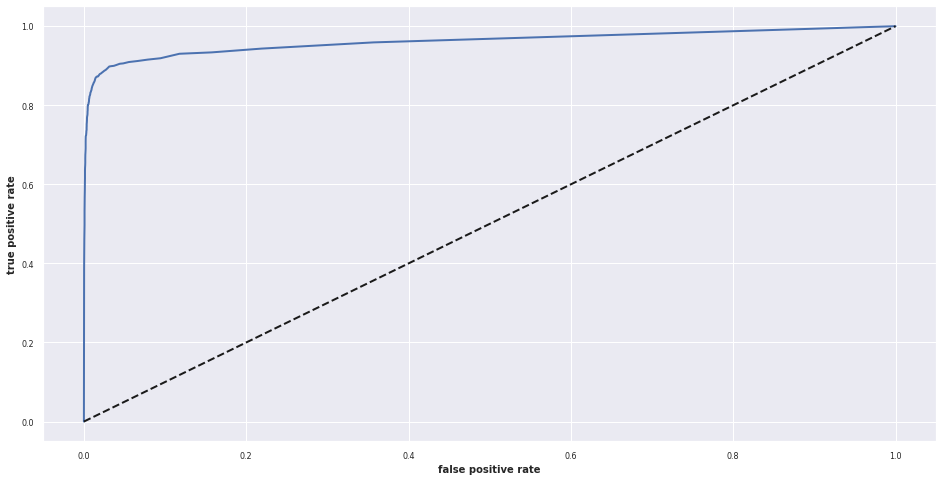

In [ ]:
fpr,tpr,thresholds=roc_curve(y_train,y_score_rf)

plot_roc_curve(fpr,tpr)
plt.show()

Valutiamo l'algoritmo sul test set

In [ ]:
threshold=0.5 #valore della threshold scelto come esempio per plottare la matrice di confusione
y_pred_test_rf=best_rf.predict_proba(X_test)[:,1]
print(f'AUC_test:{roc_auc_score(y_test,y_pred_test_rf)}')

AUC_test:0.9606456481231478


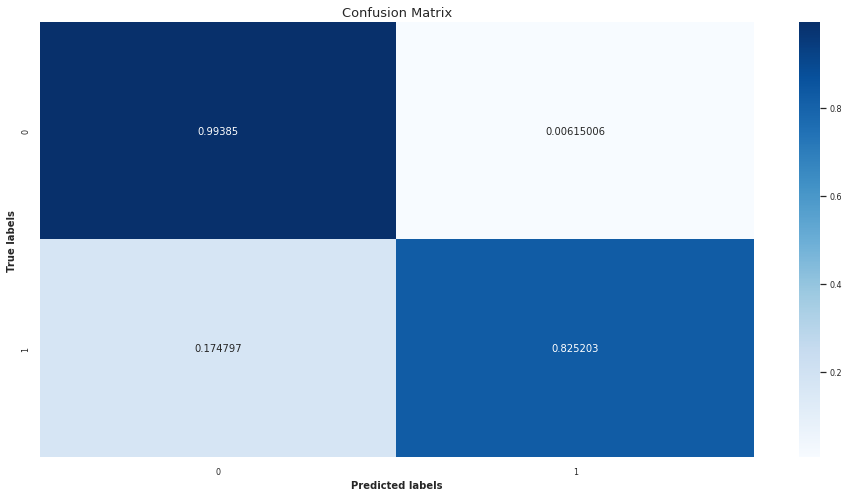

In [ ]:
y_rf_th= y_pred_test_rf > threshold

ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test,y_rf_th,normalize='true'), cmap=plt.cm.Blues, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1']);

# **SVM**
The support vector machine is another type of linear classifier, as its solution consists of hyperplanes dividing the space of the features into regions that identify the class to which each element belongs.

Associated with the hyperplane in the SVM we find the geometric margin γ, that is the distance from the hyperplane of the closest point belonging to one of the classes.

The SVM aims to find a separation hyperplane with the largest possible margin, under suitable restrictions.


We begin by introducing what is called as :

* **HARD MARGIN SVM CLASSIFIER**

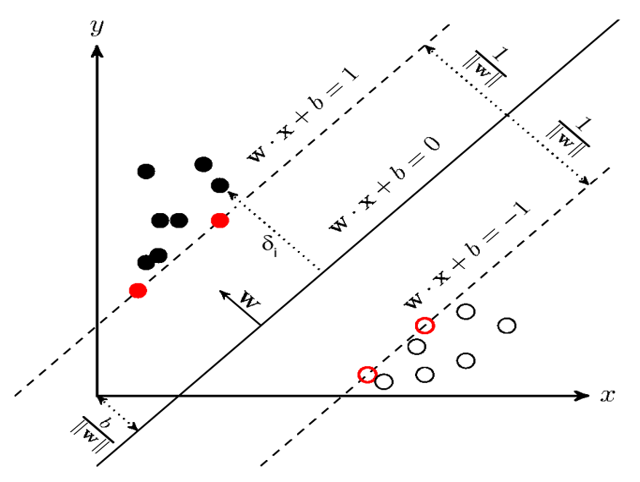

This classifier, just like the perceptron,
does not provide acceptable solutions in the case of linear non-separability of the features.

Geometrically the distance of a point $\vec{x_n}$ from the decision surface is :

$$\gamma_{n} = \frac{t_ny(\vec{x_n})}{||\vec{w}||}=\frac{t_n(\vec{w}^T\phi(\vec{x_n})+b)}{||\vec{w}||}$$

therefore maximizing the margin basically means :

$$ \arg\max_{\vec{w},b}\frac{1}{||\vec{w}||}\min_n[t_n(\vec{w}^T\phi(\vec{x_n})+b]$$

If we multiply $\vec{w}$ and b by a coefficient k, the margin remains unchanged, that is, it is defined up to a constant. This degree of freedom can be used to set $t_ny(\vec{x_n})=1$ for the point closest to the decision surface. Consequently the previous problem boils down to finding the maximum of $\gamma = ||\vec{w}||^{-1}$, which is equivalent to findind :

$$\arg\min_{\vec{w},b} \frac{1}{2}||\vec{w}||^2$$
with the condition
: $t_n(\vec{w}^T\phi(\vec{x_n})+b)\geq 1 ,\forall n$.

This is a convex quadratic optimization problem **(QP)** that is, it is a problem with a quadratic function to be optimized with a linear constraint.

From the theory of optimization it follows that this type of problem has its own dual version which presents the same minimum as the primal.

To arrive at the dual form, we introduce the Lagrange multipliers $\lambda_n$ an and the Lagrangian function :

$$L(\vec{w},b,\vec{\lambda})=\frac{1}{2}||\vec{w}||^2-\sum_{n=1}^{N}\lambda_n[t_n(\vec{w}^T\phi(\vec{x_n})+b)-1]$$


then we will have the same optimal as the previous problem solving

$$\max_\lambda\min_{\vec{w},b} L(\vec{w},b,\vec{\lambda})$$

By imposing equal to zero the derivatives of the Lagrangian with respect to $\vec{w}$ and $b$ we find:

$$\vec{w}=\sum_{n=1}^{N}\lambda_nt_n\phi(\vec{x_n})$$
$$0=\sum_{n=1}^{N}\lambda_nt_n$$

which we can use to remove $\vec{w}$ and $ b $ from the Lagrangian thus obtaining the following problem

$$L(\vec{\lambda})=\sum_{n=1}^{N}\lambda_n-\frac{1}{2}\sum_{n=1}^{N}\sum_{m=1}^{N}\lambda_n\lambda_mt_nt_mk(\vec{x_n},\vec{x_m})$$ subject to constraints
$$\lambda_n\geq0, \forall n$$ $$\sum_{n=1}^{N}\lambda_nt_n=0$$

This is the **dual representation** of the problem.
Thanks to the optimal values ​​of $\vec{w}$ found we can rewrite the predictive function as follows

 $$y(\vec{x})=\sum_{n=1}^{N}\lambda_nt_nk(\vec{x_n},\vec{x_m})+b$$


The defined optimization problem satisfies the *Karush-Kuhn-Tucker* relations :

$$\lambda_n\geq0$$ $$t_ny(\vec{x_n})-1\geq0$$ $$\lambda_n[t_ny(\vec{x_n})-1]=0$$
\
The first two conditions add nothing new to what we already know.

The **third** , however, tells us that the Lagrange multipliers are zero for all points in the dataset that are not $\color{red}{{active}}$ points.

This means that the number of parameters to be determined in the dual problem is actually much less than N.

* **SOFT MARGIN SVM CLASSIFIER**

$$t_ny(\vec{x_n})\geq1-\xi_n, \forall n$$

$$\arg\min_{\vec{w},b} C\sum_{n=1}^{N}\xi_n+\frac{1}{2}||\vec{w}||^2$$

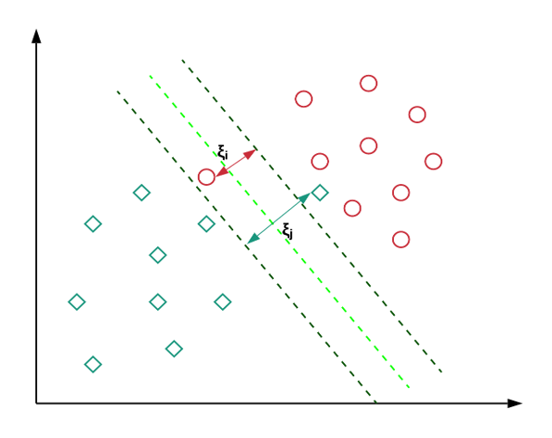

In this version the SVM provides an acceptable solution even in the case of classes that are not (completely) linearly separable.

It can be shown that SVM with soft margin is an optimization problem characterized by the presence of a loss function on the **slack variables**, which is nothing more than a **Hinge-loss** plus the addition of a regularizer **$R_ {2}$**.

**Kernel-Trick**

Kernel functions conceptually do the same thing as base functions, but without actually applying a mapping to the features, which is often computationally prohibitive. This allows to have a considerable advantage from the computational point of view especially when the number of features is high.

**Example of a polynomial kernel function**


Let $x_{1}$ and $x_{2}$ $\in$ $\mathbb{R}^{2}$ and $k(x_{1}, x_{2})$ defined as :

$$k(x_{1}, x_{2}) = (x_{1} · x_{2} )^2 = $$

$$(x_{11} ·x_{21} ·x_{12} ·x_{22})^2 = $$

$$\phi(x_{1})·\phi(x_{2}) $$

with $\phi$ defined as:

$$\phi(x) = (x_{1}^2,x_{2}^2, x_{1}x_{2},x_{2}x_{1})^T$$
\
Using a kernel like the one just defined we can reproduce the dot product of quadratic plonymial functions $\phi$ without actually applying these functions.

Apparently not much seems to have changed,

indeed we moved from a $d$-dimensional space to a $ (d + 1) ^ 2 $ - dimensional space.

But thinking about it carefully, we went from a mapping algorithm of order $ O (N ^ 2) $ to one of order $ O (N) $,\
that's the **trick**.



We will use the Gaussian RBF kernel function :

 $$K(\vec{a},\vec{b})=exp(-\gamma||\vec{a}-\vec{b}||^2)$$

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

dataset=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Pulsar.csv', sep=',')
#dataset= dataset.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=True)  #eliminiamo le righe duplicate
dataset_final = dataset.drop(['EK', 'Skewness_DMSNR_Curve', 'SD_DMSNR_Curve'], axis=1)


Mounted at /content/drive/


In [ ]:
X, y= dataset_final.iloc[:,:-1].values, dataset_final.iloc[:,-1].values

In [ ]:
# division into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42,stratify=y)

# model training
rbf_kernel_svm_clf=Pipeline([
                             ('scaler',StandardScaler()),
                             ('svm_clf', SVC(kernel='rbf',class_weight='balanced',probability=True))
                             ])
rbf_kernel_svm_clf.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(class_weight='balanced', probability=True))])

We then evaluate the model on the training set :

In [ ]:
predict_train=rbf_kernel_svm_clf.predict(X_train)
proba_train=rbf_kernel_svm_clf.predict_proba(X_train)[:,1]

print(f'AUC_train:{roc_auc_score(y_train,proba_train)}')

AUC_train:0.9706206684277097


We evaluate the model with cross-validation :

In [ ]:
# Stratifiedkfold
skfolds=StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
scores=cross_val_score(rbf_kernel_svm_clf,X_train,y_train,cv=skfolds,scoring='roc_auc')
display_scores(scores)

scores: [0.97682924 0.96841522 0.97342783 0.96118027 0.95881651]
mean: 0.9677338129875881
Standard deviation: 0.0069004370209323025


We look for a better model, if there is one, by modifying the C and $\gamma$ parameters :

In [ ]:
neg, pos = np.bincount(dataset['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 0: {:.2f}'.format(weight_for_0))

Examples:
    Total: 17898
    Positive: 1639 (9.16% of total)

Weight for class 1: 5.46
Weight for class 0: 0.55


In [ ]:
param_grid=[
    {'C': list(np.linspace(1,10,10)), 'gamma': list(np.linspace(0.01,1,10)) }
]


svm_clf=SVC(kernel='rbf',class_weight=class_weight,probability=True)
grid_search=GridSearchCV(svm_clf,param_grid,cv=5,scoring='roc_auc',return_train_score=True)

sc=StandardScaler() #mean=0, variance=1
X_train=sc.fit_transform(X_train)
#X_val=sc.transform(X_val)
#X_test=sc.transform(X_test)

grid_search.fit(X_train,y_train)
grid_search.best_params_

{'C': 10.0, 'gamma': 0.01}

We evaluate the best model on the training set :

In [ ]:
best_SVM=grid_search.best_estimator_ # the best model found via Grid_Search
predict_train=best_SVM.predict(X_train)
proba_train=best_SVM.predict_proba(X_train)[:,1]
print(f'AUC_train:{roc_auc_score(y_train,proba_train)}')

AUC_train:0.9738792081236053


We evaluate the best model with cross-validation :




In [ ]:
y_score=cross_val_predict(best_SVM,X_train,y_train,cv=5,method='predict_proba')[:,1]
scores=cross_val_score(best_SVM,X_train,y_train,cv=5,scoring='roc_auc')
display_scores(scores)

[0.0121171  0.03281665 0.01886197 0.00524069 0.0114967  0.01422906
 0.01196594 0.00653993 0.01208622 0.01844548 0.01221605 0.00798497
 0.01944872 0.00748535 0.02606763 0.80704268 0.00513478 0.02857638
 0.0040601  0.0115712 ]
scores: [0.96929232 0.97668488 0.9713074  0.96929609 0.97960108]
mean: 0.9732363533760082
Standard deviation: 0.004176217893935032


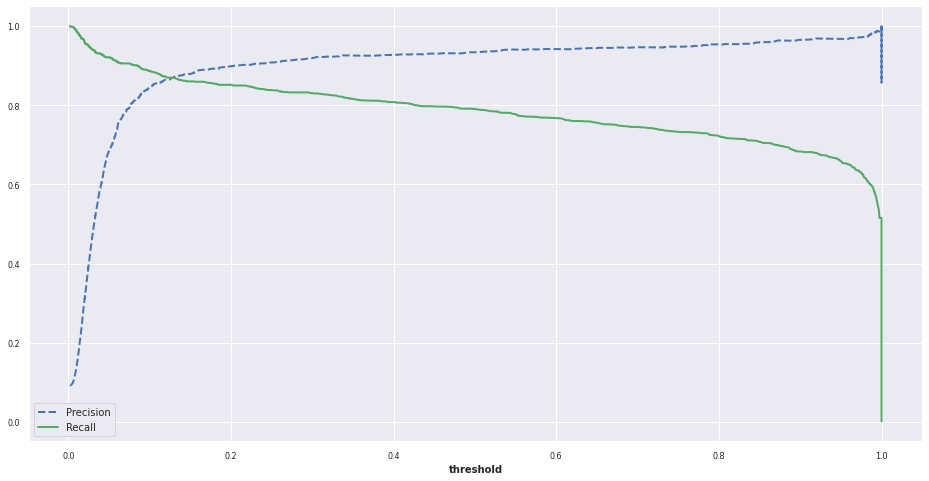

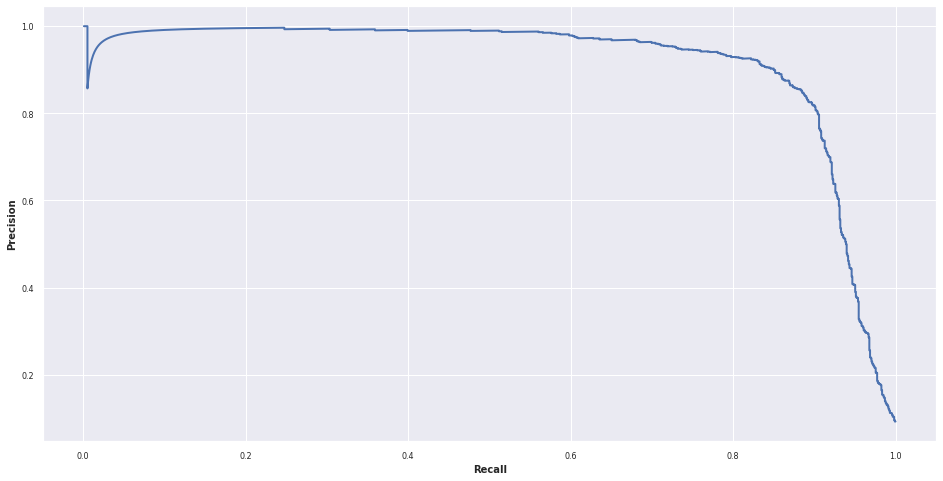

In [ ]:
# precision and recall trends
precisions,recalls,thresholds=precision_recall_curve(y_train,y_score)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

plot_decision_vs_recall(precisions, recalls, thresholds)
plt.show()

Evaluation of the model on the test set :


In [ ]:
X_test=sc.transform(X_test) # the instantiated model does not transform the dataset, we have to do it by hand
threshold= 0.4 # threshold value chosen as an example to plot the confusion matrix
proba_test=best_SVM.predict_proba(X_test)[:,1]
predict_test=np.multiply(best_SVM.predict_proba(X_test)[:,1]>threshold,1) # binary vector depending on whether the probability is greater or less than a threshold to be chosen

AUC_test:0.9651979853131865


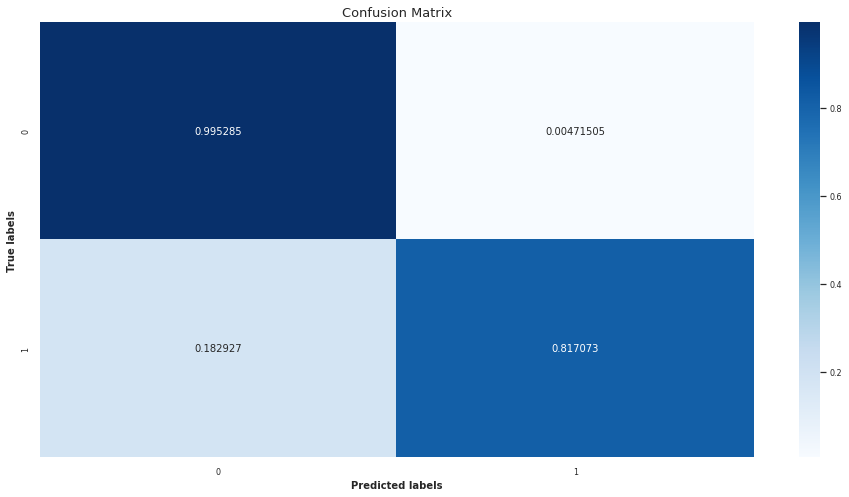

In [ ]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test,predict_test,normalize='true'), cmap=plt.cm.Blues, annot=True, fmt='g', ax=ax);  # annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1']);

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

dataset=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Pulsar.csv', sep=',')
#dataset= dataset.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=True)  #eliminiamo le righe duplicate
dataset_final = dataset.drop(['EK', 'Skewness_DMSNR_Curve', 'SD_DMSNR_Curve'], axis=1)
X, y= dataset_final.iloc[:,:-1].values, dataset_final.iloc[:,-1].values

Mounted at /content/drive/


# **NEURAL NETWORK**

Linear models for classification and regression take the form :

$$y(\vec{x},\vec{w})=f\bigg(\sum_{j=1}^{M}w_j\phi_{j}(\vec{x})\bigg)$$

The purpose of neural networks is to extend this model by making basic functions $\phi_j$ dependent to the coefficients $w_j$.

This can be done by substituting expression for the basic functions $z_j=h(a_j)$ with :

$$a_j=\sum_{i=1}^{D}w_{ji}^{(1)}x_i+w_{j0}^{(1)}$$

$z_j$ are called *hidden units*.

Referring to the initial expression of $ y $ we still have to combine the $ z_j $ with other parameters:
$$a_k=\sum_{j=1}^{M}w_{kj}^{(2)}z_j+w_{k0}^{(2)}  $$ and therefore *for each output of the neural network*

$$y_k=\sigma(a_k)$$
If we compact the expression of $ a_j $ :
$$a_j=\sum_{i=0}^{D}w_{ji}^{(1)}x_i$$
by making $ y_k $ explicit we get :
$$y_k(\vec{x},\vec{w})=\sigma\bigg(\sum_{j=0}^{M}w_{kj}^{(2)}h\bigg(\sum_{i=0}^{D}w_{ji}^{(1)}x_i\bigg)\bigg)$$

For the case of binary classification we can define the cost function as in the case of logistc regression:

$$E(\vec{w})=-\sum_{n=1}^{N}\big(t_nln(y_n)+(1-y_n)ln(1-y_n)\big)$$

We note that for a binary classification, only one output in the neural network is enough which predicts the possibility of an element belonging to a class. The probability of the second class is thus uniquely determined by the first.

In the expression of $ E (\vec {w}) $ then $ y_n $ is the output returned by the neural network once we input the element $ x_n $.


**Error Backpropagation**

Having the cost function, we can minimize it for example by descending the gradient. To do this we must calculate the derivatives of the cost function with respect to the parameters $ w_ {ji} $. The back propagation algorithm helps us in the computation of these derivatives.

By the chain rule we have :

$$\frac{\partial E_n}{\partial w_{ji}}=\frac{\partial E_n}{\partial a_j}\frac{\partial a_j}{\partial w_{ji}}=\delta_jz_i$$

In this expression $ z_j $ we know it because it is exactly what the network has calculated of the "forward" phase.

It remains to calculate $\delta_j \equiv \frac {\partial E_n} {\partial a_j} $.

The result that is always valid applies to the network output :

$$\delta_k=y_k-t_k$$
while for hidden units
$$\delta_j=\sum_k\frac{\partial E_n}{\partial a_k}\frac{\partial a_k}{\partial a_j}$$

The sum is done on all k-units to which unit j is connected.

Finally using the previous equations for $ a_k $ :

$$\delta_j=h^{'}(a_j)\sum_{k}w_{kj}\delta_k$$

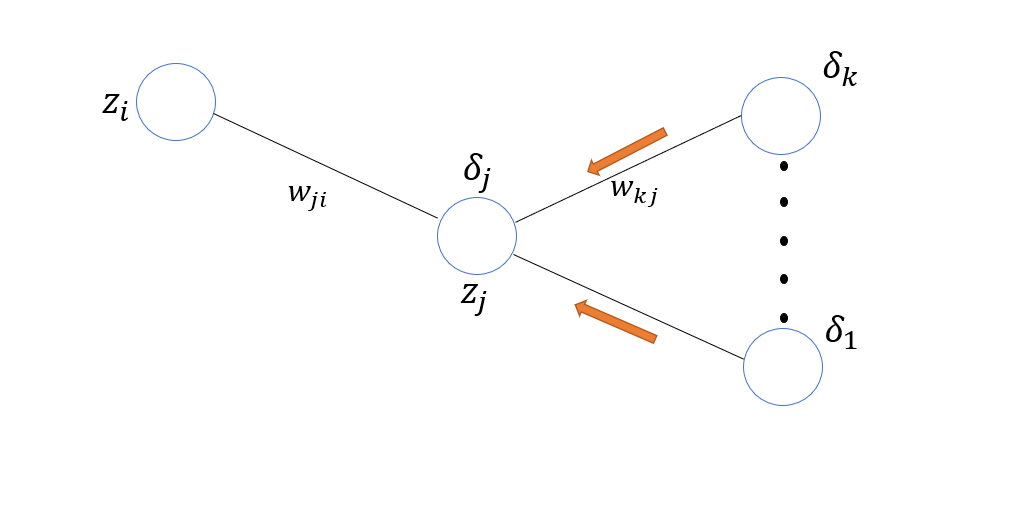

In [ ]:
model=keras.models.Sequential([
                               keras.layers.InputLayer(5),
                               keras.layers.Dense(5,activation='elu',kernel_initializer="he_normal"),

                               keras.layers.Dense(1,activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 30        
                                                                 
 dense_1 (Dense)             (None, 1)                 6         
                                                                 
Total params: 36
Trainable params: 36
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[tf.keras.metrics.AUC(name='AUC'),tf.keras.metrics.Precision(name='precision',thresholds=0.7)])

In [ ]:
X_train_full,X_test,y_train_full,y_test=train_test_split(X,y,test_size=0.3,random_state=42,stratify=y)

In [ ]:
sc=StandardScaler() #mean=0, variance=1
X_train_full=sc.fit_transform(X_train_full)
X_test=sc.transform(X_test)

In [ ]:
X_val,X_train=X_train_full[:2000],X_train_full[2000:]
y_val,y_train=y_train_full[:2000],y_train_full[2000:]
print(f'numero di esempi in X_train: {len(y_train)}')
print(f'numero di esempi in X_val: {len(y_val)}')

numero di esempi in X_train: 10528
numero di esempi in X_val: 2000


In [ ]:
neg, pos = np.bincount(dataset['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 17898
    Positive: 1639 (9.16% of total)



In [ ]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 1: {:.2f}'.format(weight_for_0))
print('Weight for class 0: {:.2f}'.format(weight_for_1))

Weight for class 1: 0.55
Weight for class 0: 5.46


In [ ]:
history=model.fit(X_train,y_train,epochs=30,validation_data=(X_val,y_val),class_weight=class_weight)

Epoch 1/30
329/329 [==============================] - 2s 3ms/step - loss: 0.6687 - AUC: 0.6882 - precision: 0.8776 - val_loss: 0.3950 - val_AUC: 0.9411 - val_precision: 0.8280
Epoch 2/30
329/329 [==============================] - 1s 2ms/step - loss: 0.3064 - AUC: 0.9585 - precision: 0.7824 - val_loss: 0.2784 - val_AUC: 0.9493 - val_precision: 0.6963
Epoch 3/30
329/329 [==============================] - 1s 2ms/step - loss: 0.2515 - AUC: 0.9624 - precision: 0.7539 - val_loss: 0.2352 - val_AUC: 0.9522 - val_precision: 0.7209
Epoch 4/30
329/329 [==============================] - 1s 2ms/step - loss: 0.2334 - AUC: 0.9636 - precision: 0.7759 - val_loss: 0.2108 - val_AUC: 0.9544 - val_precision: 0.7723
Epoch 5/30
329/329 [==============================] - 1s 2ms/step - loss: 0.2235 - AUC: 0.9653 - precision: 0.8030 - val_loss: 0.1960 - val_AUC: 0.9558 - val_precision: 0.8061
Epoch 6/30
329/329 [==============================] - 1s 2ms/step - loss: 0.2172 - AUC: 0.9661 - precision: 0.8238 - val

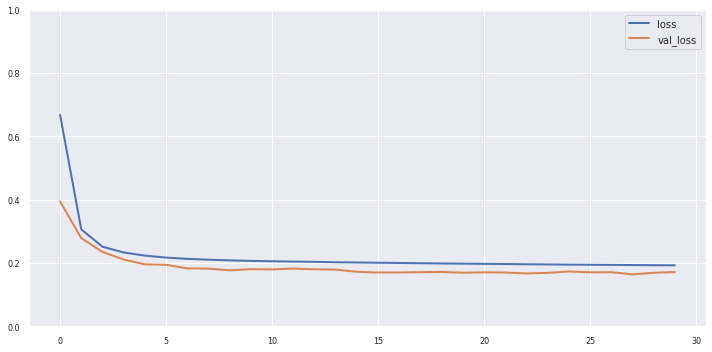

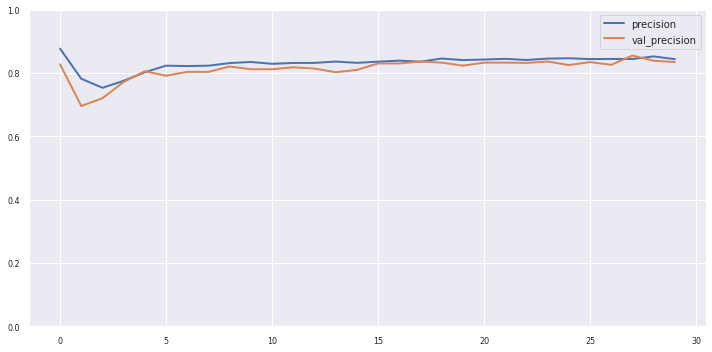

In [ ]:
#plt.subplot(2,1,1)
plt.figure(figsize=(10,5))
plt.plot(history.epoch,history.history['loss'],label='loss')
plt.plot(history.epoch,history.history['val_loss'],label='val_loss')
#plt.plot(history.epoch,history.history['accuracy'],label='accuracy')
#plt.plot(history.epoch,history.history['val_accuracy'],label='val_accuracy')
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.legend()
plt.tight_layout()
plt.show()
plt.figure(figsize=(10,5))
plt.plot(history.epoch,history.history['precision'],label='precision')
plt.plot(history.epoch,history.history['val_precision'],label='val_precision')
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.legend()
plt.tight_layout()
plt.show()

The rapid descent of the **loss**, of about .5, compared to a **precision** that remains rather stable,

indicates that the network is learning to minimize **false negatives**, in our case class 0 classified as class 1.


**SELF-NORMALIZING** neural network

We will build the neural network with the *self-normalizing* property:

- the output of each layer tends to preserve mean 0 and variance 1

This self-normalizing property helps prevent the *vanishing | exploding gradient* problem. A self-normalizing neural network must have the following characteristics:

* The input must be standardized
* Activation function: **SELU** (Scaled ELU)
$$ \lambda x \space \space \text {for} \space x> 0 $$ SELU: $$ \lambda \alpha (e ^ x-1) \space \space \text {for} \space x <0 $$
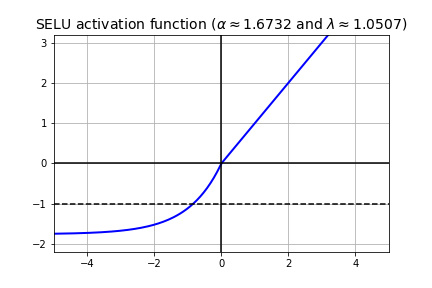
* The weights of each hidden-layer must be initialized with the **LeCun normal** initialization. This is done by sampling a normal distribution centered in 0 and with standard deviation

$$ std = \sqrt \frac {1} {fan_ {in}} $$

* Regularization: Alpha dropout
* The model used must be a sequential model
* All hidden layers must be dense

We note that by default the neural network in keras is initialized with the **Glorot** initialization: $ std = \sqrt {\frac {1} {fan_ {avg}}} $.

In [ ]:
best_model=keras.models.Sequential([
                               keras.layers.InputLayer(5),
                               keras.layers.Dense(25,activation='selu',kernel_initializer='lecun_normal'),
                               keras.layers.AlphaDropout(rate=0.01),
                               keras.layers.Dense(25,activation='selu',kernel_initializer='lecun_normal'),
                               keras.layers.AlphaDropout(rate=0.01),
                               keras.layers.Dense(25,activation='selu',kernel_initializer='lecun_normal'),
                               keras.layers.AlphaDropout(rate=0.01),
                               keras.layers.Dense(25,activation='selu',kernel_initializer='lecun_normal'),
                               keras.layers.AlphaDropout(rate=0.01),
                               keras.layers.Dense(25,activation='selu',kernel_initializer='lecun_normal'),
                               keras.layers.AlphaDropout(rate=0.01),
                               keras.layers.Dense(1,activation='sigmoid')
])
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 25)                150       
                                                                 
 alpha_dropout (AlphaDropout  (None, 25)               0         
 )                                                               
                                                                 
 dense_3 (Dense)             (None, 25)                650       
                                                                 
 alpha_dropout_1 (AlphaDropo  (None, 25)               0         
 ut)                                                             
                                                                 
 dense_4 (Dense)             (None, 25)                650       
                                                                 
 alpha_dropout_2 (AlphaDropo  (None, 25)              

In [ ]:
best_model.compile(loss='binary_crossentropy',
              optimizer='nadam',
              metrics=[tf.keras.metrics.AUC(name='AUC'),tf.keras.metrics.Precision(name='precision')])
history=best_model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=50,class_weight=class_weight)

Epoch 1/50
329/329 [==============================] - 3s 4ms/step - loss: 0.2487 - AUC: 0.9575 - precision: 0.5015 - val_loss: 0.1715 - val_AUC: 0.9599 - val_precision: 0.6475
Epoch 2/50
329/329 [==============================] - 1s 3ms/step - loss: 0.2158 - AUC: 0.9640 - precision: 0.6327 - val_loss: 0.1414 - val_AUC: 0.9624 - val_precision: 0.7467
Epoch 3/50
329/329 [==============================] - 1s 3ms/step - loss: 0.2102 - AUC: 0.9648 - precision: 0.6690 - val_loss: 0.1497 - val_AUC: 0.9644 - val_precision: 0.7348
Epoch 4/50
329/329 [==============================] - 1s 3ms/step - loss: 0.2025 - AUC: 0.9672 - precision: 0.6850 - val_loss: 0.1976 - val_AUC: 0.9636 - val_precision: 0.6486
Epoch 5/50
329/329 [==============================] - 1s 3ms/step - loss: 0.2046 - AUC: 0.9661 - precision: 0.6853 - val_loss: 0.1594 - val_AUC: 0.9692 - val_precision: 0.7389
Epoch 6/50
329/329 [==============================] - 1s 3ms/step - loss: 0.1986 - AUC: 0.9679 - precision: 0.6869 - val

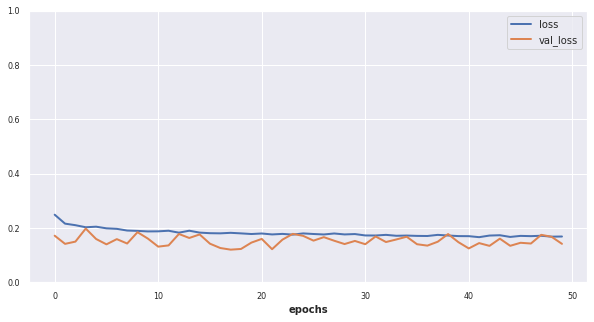

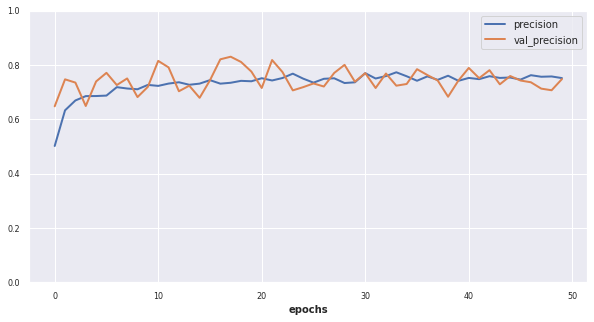

In [ ]:
#plt.subplot(2,1,1)
plt.figure(figsize=(10,5))
plt.plot(history.epoch,history.history['loss'],label='loss')
plt.plot(history.epoch,history.history['val_loss'],label='val_loss')
plt.xlabel('epochs')
#plt.plot(history.epoch,history.history['accuracy'],label='accuracy')
#plt.plot(history.epoch,history.history['val_accuracy'],label='val_accuracy')
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.legend()
plt.show()
plt.figure(figsize=(10,5))
plt.plot(history.epoch,history.history['precision'],label='precision')
plt.plot(history.epoch,history.history['val_precision'],label='val_precision')
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.legend()
plt.xlabel('epochs')
plt.show()

In [ ]:
def build_model(n_hidden=5, n_neurons=25, input_shape=[5]):
  model = keras.models.Sequential()
  options = {"input_shape": input_shape}
  for layer in range(n_hidden):
    model.add(keras.layers.Dense(n_neurons, activation="selu",kernel_initializer="lecun_normal",**options))
    model.add(keras.layers.AlphaDropout(rate=0.01))
    options = {}
  model.add(keras.layers.Dense(1,activation='sigmoid', **options))
  optimizer = 'nadam'
  model.compile(loss="binary_crossentropy", optimizer=optimizer,metrics=[tf.keras.metrics.AUC(from_logits=True,name='AUC'),tf.keras.metrics.Precision(thresholds=0.8),'accuracy'])
  return model
keras_class = keras.wrappers.scikit_learn.KerasClassifier(build_model)
keras_class.fit(X_train,y_train,epochs=50,validation_data=(X_val,y_val),class_weight=class_weight)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  if sys.path[0] == '':


329/329 [==============================] - 3s 4ms/step - loss: 0.2464 - AUC: 0.9543 - precision: 0.7959 - accuracy: 0.9198 - val_loss: 0.1848 - val_AUC: 0.9577 - val_precision: 0.7941 - val_accuracy: 0.9400
Epoch 2/50
329/329 [==============================] - 1s 3ms/step - loss: 0.2138 - AUC: 0.9628 - precision: 0.8342 - accuracy: 0.9444 - val_loss: 0.2072 - val_AUC: 0.9583 - val_precision: 0.8079 - val_accuracy: 0.9360
Epoch 3/50
329/329 [==============================] - 1s 3ms/step - loss: 0.2125 - AUC: 0.9632 - precision: 0.8487 - accuracy: 0.9468 - val_loss: 0.1589 - val_AUC: 0.9631 - val_precision: 0.8681 - val_accuracy: 0.9615
Epoch 4/50
329/329 [==============================] - 1s 3ms/step - loss: 0.2035 - AUC: 0.9663 - precision: 0.8544 - accuracy: 0.9548 - val_loss: 0.2002 - val_AUC: 0.9623 - val_precision: 0.8010 - val_accuracy: 0.9465
Epoch 5/50
329/329 [==============================] - 1s 3ms/step - loss: 0.2035 - AUC: 0.9664 - precision: 0.8233 - accuracy: 0.9506 - val

**If** we want to make a fairer comparison of the AUC values ​​on the training and validation set, it is not enough to look at the previous results.

This is because the **dropout** regularization is active only during the training phase, therefore the results on the previously printed training set are affected by this regularization.

We re-evaluate the performance on the training set with "predict".

In [ ]:
predict_train=keras_class.predict(X_train)
proba_train=keras_class.predict_proba(X_train)[:,1]
print(f'AUC_train:{roc_auc_score(y_train,proba_train)}')

AUC_train:0.9785339660789565


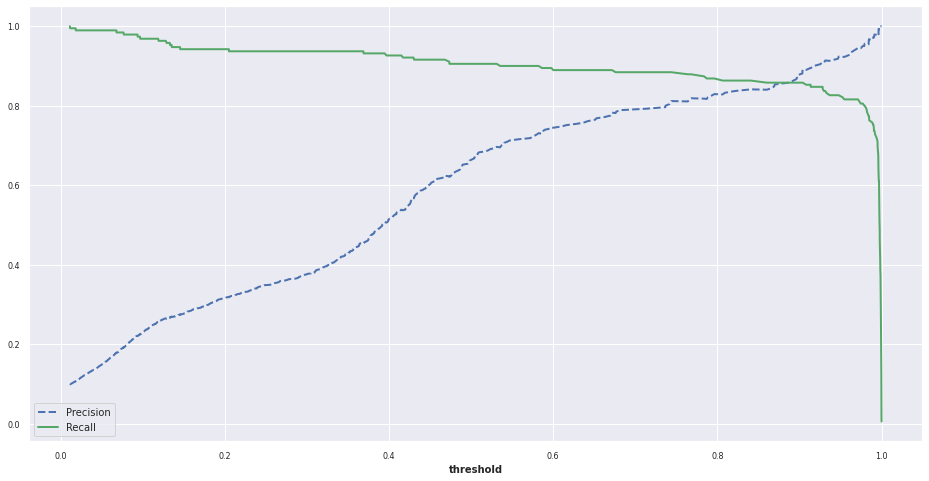

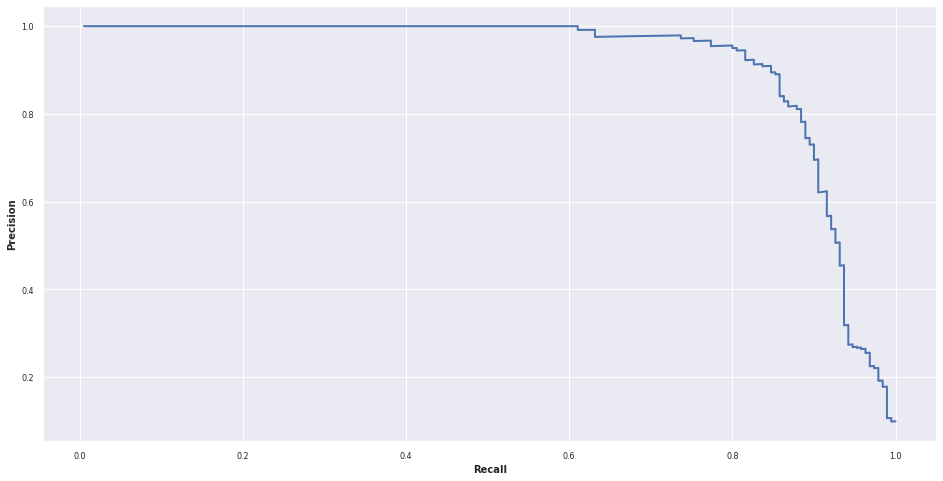

In [ ]:
predict_DNN=keras_class.predict_proba(X_val)[:,1]
precisions,recalls,thresholds=precision_recall_curve(y_val,predict_DNN)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

plot_decision_vs_recall(precisions, recalls, thresholds)
plt.show()

**EVALUATION** ON THE TEST SET

In [ ]:
threshold=0.9 # threshold value chosen as an example to plot the confusion matrix

proba_test=keras_class.predict_proba(X_test)[:,1]
predict_test=np.multiply(keras_class.predict_proba(X_test)[:,1]>threshold,1) # binary vector depending on whether the probability is greater or less than a threshold to be chosen
print(f'AUC_train:{roc_auc_score(y_test,proba_test)}')

AUC_train:0.9711805451387847


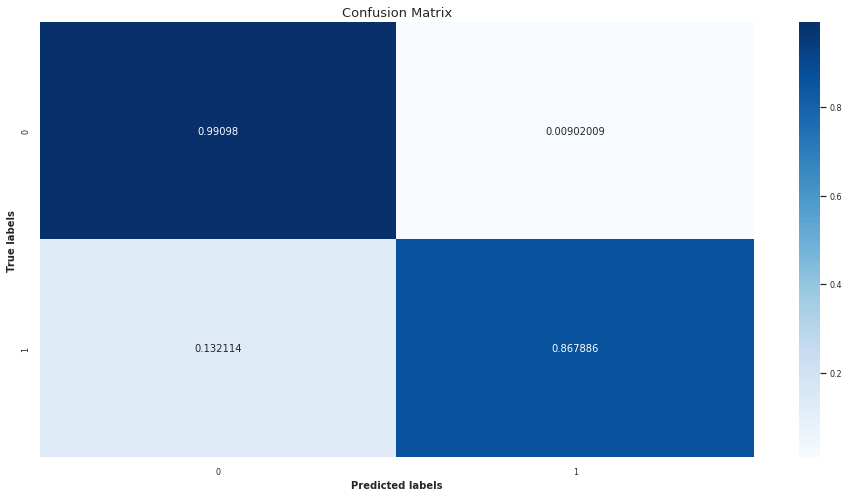

In [ ]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test,predict_test,normalize='true'), cmap=plt.cm.Blues, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1']);

# **AdaBoost Classifier**

# **How does the AdaBoost algorithm work?**
It works in the following steps:

- Initially, Adaboost selects a training subset randomly.
- It iteratively trains the AdaBoost machine learning model by selecting the training set based on the accurate prediction of the last training.

- It assigns the higher weight to wrong classified observations so that in the next iteration these observations will get the high probability for classification.

- Also, It assigns the weight to the trained classifier in each iteration according to the accuracy of the classifier. The more accurate classifier will get high weight.

- This process iterate until the complete training data fits without any error or until reached to the specified maximum number of estimators.

- To classify, perform a "vote" across all of the learning algorithms you built.
\
\
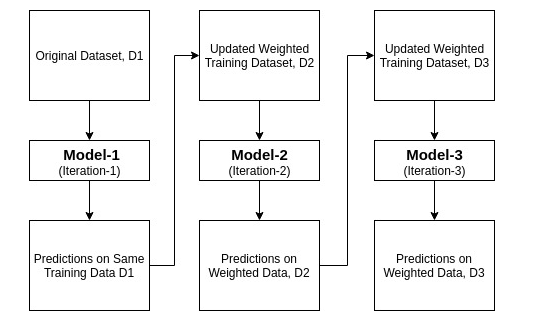

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

dataset=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Pulsar.csv', sep=',')
#dataset= dataset.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=True)  #eliminiamo le righe duplicate
dataset_final = dataset.drop(['EK', 'Skewness_DMSNR_Curve', 'SD_DMSNR_Curve'], axis=1)
X, y= dataset_final.iloc[:,:-1].values, dataset_final.iloc[:,-1].values

Mounted at /content/drive/


Building the AdaBoost Model
- Let's create the AdaBoost Model using Scikit-learn.
- AdaBoost uses Decision Tree Classifier as default Classifier.

In [ ]:
abc_clf = AdaBoostClassifier( random_state=42)

# division into training set and test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

abc_clf.fit(X_train, y_train)

AdaBoostClassifier(random_state=42)

" The most important parameters are **base_estimator**, **n_estimators**, and **learning_rate** " (Adaboost Classifier, *Chris Albon*)

- **base_estimator** : It is a weak learner used to train the model. It uses **DecisionTreeClassifier** as default weak-learner for training purpose. One might as well specify different machine learning algorithms.
- **n_estimators** : Number of weak learners to train iteratively.
- **learning_rate** : It contributes to the weights of weak learners. It uses 1 as a default value.





**Evaluate Model**  with cross-validation :

In [ ]:
criterio=['gini', 'entropy']
for crit in criterio:
    abc_1 = AdaBoostClassifier( random_state=42)
    abc_1.fit(X_train, y_train)
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    print('AUC %s:' %(crit))
    print(cross_val_score(rf_1, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1))

AUC gini:
[0.96677809 0.97717964 0.97738022 0.96584063 0.96681626 0.96418332
 0.97439062 0.97276496 0.9699868  0.97423562 0.98253083 0.96944009
 0.98361638 0.96444482 0.95868604]
AUC entropy:
[0.96677809 0.97717964 0.97738022 0.96584063 0.96681626 0.96418332
 0.97439062 0.97276496 0.9699868  0.97423562 0.98253083 0.96944009
 0.98361638 0.96444482 0.95868604]


We find  the optimal parameters :


In [ ]:
clf = Pipeline([

    ('clf', AdaBoostClassifier())
])

parameters = {
    'clf__n_estimators': [20, 50, 70, 100],
    'clf__learning_rate' : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
    }

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs_clf = GridSearchCV(clf, parameters, cv=kfold, n_jobs=-1)
gs_clf = gs_clf.fit(X_train, y_train)
print("Best score accurracy = %.3f%%" %((gs_clf.best_score_)*100.0))
print("Best parameters are : ")
print(gs_clf.best_params_)

Best score accurracy = 97.486%
Best parameters are : 
{'clf__learning_rate': 0.3, 'clf__n_estimators': 100}


We evaluate the best model on the training set


In [ ]:
best_abc= gs_clf.best_estimator_ # the best model found via Grid_Search
y_score_abc = cross_val_predict(best_abc,X_train,y_train,cv=5, method='predict_proba')[:, 1]
scores_abc=cross_val_score(best_abc,X_train,y_train,cv=5,scoring='roc_auc')
display_scores(scores_abc)

scores: [0.96660741 0.97739933 0.97280603 0.96708103 0.97355738]
mean: 0.9714902339630994
Standard deviation: 0.004103776073194314


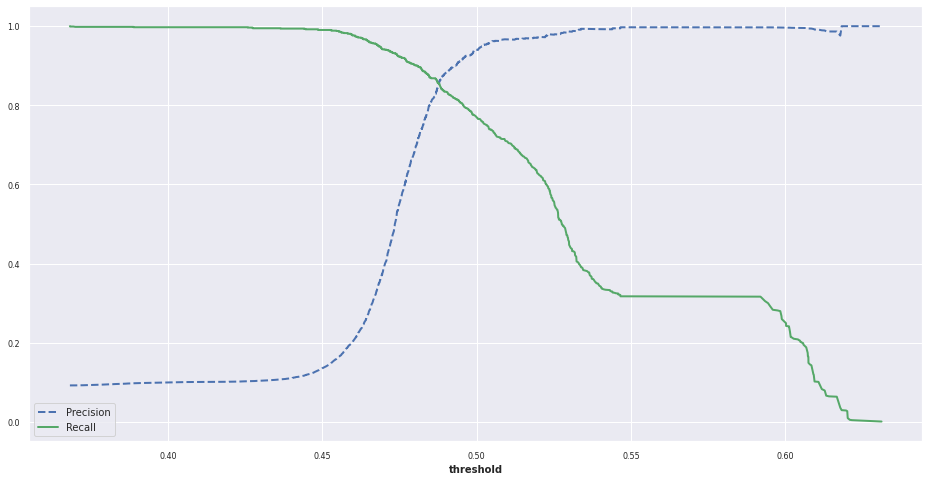

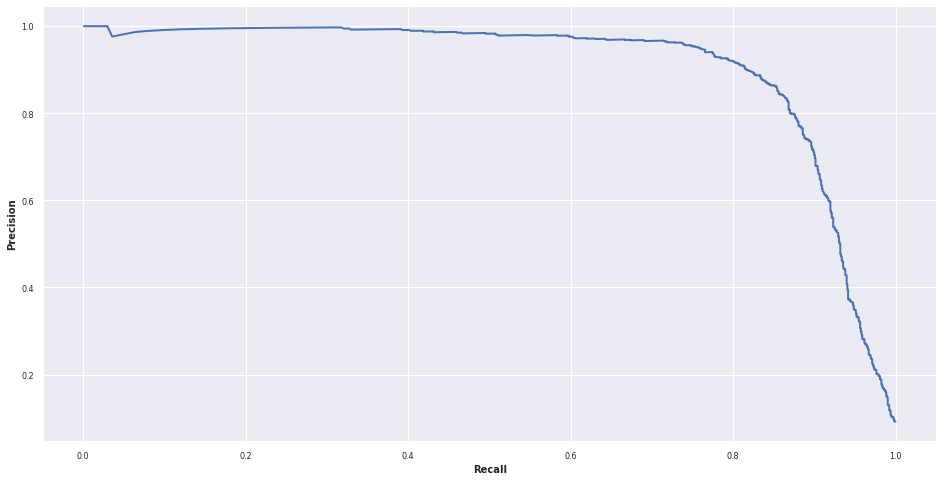

In [ ]:
# precision and recall trends
precisions,recalls,thresholds = precision_recall_curve(y_train,y_score_abc)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

plot_decision_vs_recall(precisions, recalls, thresholds)
plt.show()

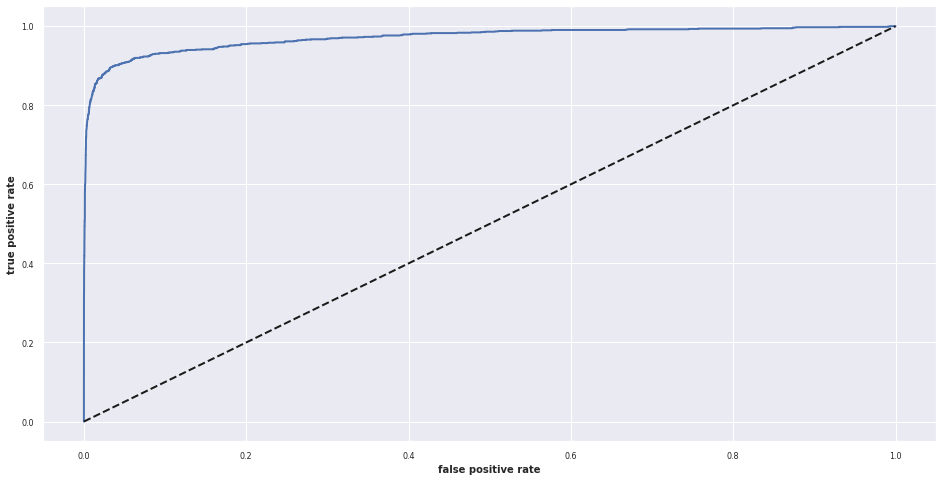

In [ ]:
fpr,tpr,thresholds=roc_curve(y_train,y_score_abc)

plot_roc_curve(fpr,tpr)
plt.show()

In [ ]:
threshold=0.48 # threshold value chosen as an example to plot the confusion matrix
y_pred_test_abc=best_abc.predict_proba(X_test)[:,1]
print(f'AUC_test:{roc_auc_score(y_test,y_pred_test_abc)}')

AUC_test:0.972289722897229


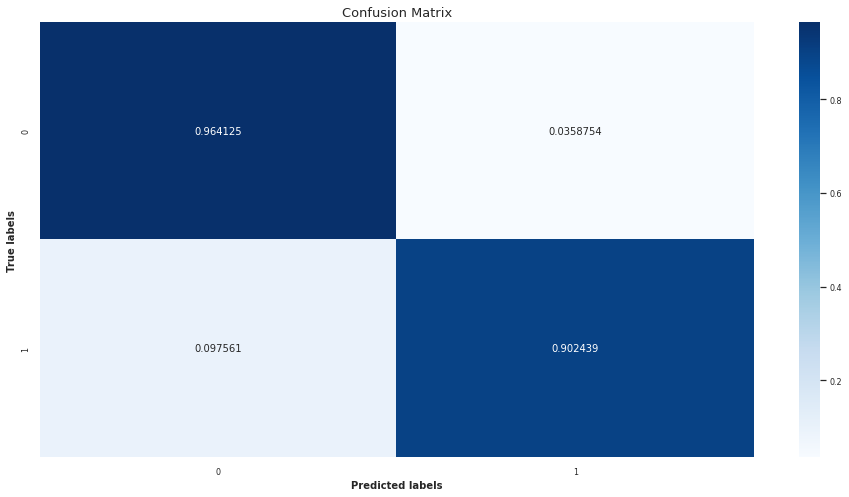

In [ ]:
y_abc_th= y_pred_test_abc > threshold

ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test,y_abc_th,normalize='true'), cmap=plt.cm.Blues, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1']);

**Pros**

- AdaBoost is easy to implement.
- It iteratively corrects the mistakes of the weak classifier and improves accuracy by combining weak learners.
- You can use many base classifiers with AdaBoost.
- AdaBoost is not prone to overfitting. This can be found out via experiment results, but there is no concrete reason available.


**Cons**
- AdaBoost is sensitive to noise data.$^{*}$  
- It is highly affected by outliers because it tries to fit each point perfectly.$^{*}$


 \*Seeing AdaBoost a **stepwise additive fit model**, leads to consider an exponential loss function.



\
\
 \
 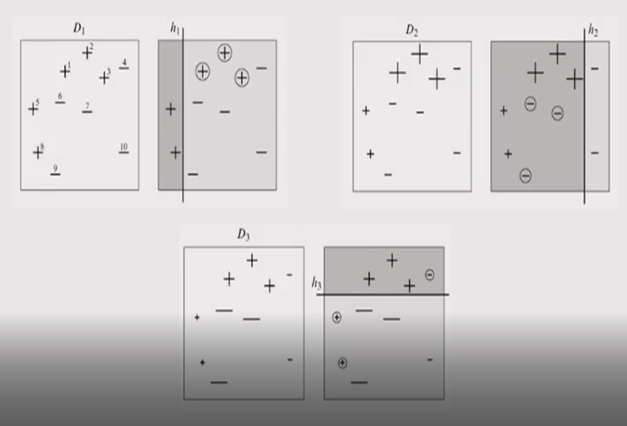

#Bibliografia
[1] M. J. Keith et al., 'The High Time Resolution Universe Pulsar Survey - I. System Configuration and Initial Discoveries',2010, Monthly Notices of the Royal Astronomical Society, vol. 409, pp. 619-627. DOI: 10.1111/j.1365-2966.2010.17325.x

[2] D. R. Lorimer and M. Kramer, 'Handbook of Pulsar Astronomy', Cambridge University Press, 2005.

[3] S. D. Bates et al., 'The high time resolution universe pulsar survey vi. an artificial neural network and timing of 75 pulsars', Monthly Notices of the Royal Astronomical Society, vol. 427, no. 2, pp. 1052-1065, 2012.

[4] R. P. Eatough et al., 'Selection of radio pulsar candidates using artificial neural networks', Monthly Notices of the Royal Astronomical Society, vol. 407, no. 4, pp. 2443-2450, 2010.
